## ***Flujo del EDA Deportivo por Match en Python***

# Paso 1. Conexion y Carga

In [2]:
# Imports básicos para análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime, timedelta
import json

# Imports para base de datos
import psycopg2
from sqlalchemy import create_engine
import sqlite3

# Imports para análisis avanzado
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Imports para visualizaciones especializadas
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Configuración de warnings y display
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Configuración de matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Configuración de seaborn
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)


In [3]:
# Paso 1. Conexión y Configuración de Base de Datos

# Configuración de la base de datos PostgreSQL
class DatabaseConfig:
    HOST = "localhost"
    PORT = 5432
    DATABASE = "2. PremierLeague"
    USER = "admin"
    PASSWORD = "GadumUNITEC123"

# Función para crear conexión a la base de datos
def create_db_connection():
    """Crear conexión a PostgreSQL usando psycopg2"""
    try:
        conn = psycopg2.connect(
            host=DatabaseConfig.HOST,
            port=DatabaseConfig.PORT,
            database=DatabaseConfig.DATABASE,
            user=DatabaseConfig.USER,
            password=DatabaseConfig.PASSWORD
        )
        print("Conexión a PostgreSQL establecida correctamente")
        return conn
    except Exception as e:
        print(f"Error conectando a la base de datos: {e}")
        return None

# Función para crear engine de SQLAlchemy es útil para pandas
def create_sqlalchemy_engine():
    """Crear engine de SQLAlchemy para usar con pandas"""
    try:
        connection_string = f"postgresql://{DatabaseConfig.USER}:{DatabaseConfig.PASSWORD}@{DatabaseConfig.HOST}:{DatabaseConfig.PORT}/{DatabaseConfig.DATABASE}"
        engine = create_engine(connection_string)
        print("Engine SQLAlchemy creado correctamente")
        return engine
    except Exception as e:
        print(f"Error creando engine SQLAlchemy: {e}")
        return None

# Probar conexión
test_conn = create_db_connection()
if test_conn:
    test_conn.close()
    print("Conexión de prueba exitosa - Base de datos disponible")
else:
    print("No se pudo establecer conexión - Verificar configuración")

Conexión a PostgreSQL establecida correctamente
Conexión de prueba exitosa - Base de datos disponible


In [4]:
# Funciones para cargar datos desde la base de datos

def load_matches_registered():
    """Cargar datos de la tabla matches_registered"""
    query = """
    SELECT 
        season_id,
        match_id,
        matchday,
        home_team,
        home_team_id,
        home_team_score,
        away_team,
        away_team_id,
        away_team_score,
        date_game
    FROM matches_registered
    ORDER BY season_id, matchday, match_id
    """
    
    try:
        engine = create_sqlalchemy_engine()
        if engine is None:
            return None
            
        df = pd.read_sql_query(query, engine)
        print(f"Datos cargados: {len(df)} matches registrados")
        print(f"Temporadas: {sorted(df['season_id'].unique())}")
        print(f"Matchdays: {df['matchday'].min()} - {df['matchday'].max()}")
        
        return df
    except Exception as e:
        print(f"Error cargando matches_registered: {e}")
        return None

def load_team_match_stats():
    """Cargar datos de la tabla team_match_stats"""
    query = """
    SELECT 
        match_id, season_id, team_id, team_name, home_away,
        ttl_gls, ttl_ast, ttl_xg, ttl_xag, ttl_pk_made, ttl_pk_att,
        ttl_yellow_cards, ttl_red_cards, ttl_gls_ag, ttl_sot_ag, ttl_saves,
        clean_sheets, ttl_pk_att_ag, ttl_pk_saved, ttl_sh, ttl_sot, pct_sot,
        ttl_avg_sh, ttl_gls_per_sot, ttl_gls_xg_diff, ttl_pass_cmp, ttl_pass_att,
        pct_pass_cmp, ttl_pass_prog, ttl_key_passes, ttl_pass_opp_box,
        ttl_cross_opp_box, ttl_pass_live, ttl_pass_dead, ttl_pass_fk,
        ttl_through_balls, ttl_switches, ttl_crosses, ttl_pass_offside,
        ttl_pass_blocked, ttl_throw_ins, ttl_ck, ttl_tkl, ttl_tkl_won,
        ttl_tkl_drb, ttl_tkl_drb_att, pct_tkl_drb_suc, ttl_blocks,
        ttl_sh_blocked, ttl_int, ttl_clearances, ttl_def_error, avg_poss,
        ttl_touches, ttl_take_on_att, ttl_take_on_suc, ttl_carries,
        ttl_carries_miscontrolled, ttl_carries_dispossessed, ttl_pass_rcvd,
        ttl_pass_prog_rcvd, ttl_fls_ag, ttl_fls_for, ttl_offside, ttl_og,
        ttl_ball_recov, ttl_air_dual_won, ttl_air_dual_lost, players_count
    FROM team_match_stats
    ORDER BY season_id, match_id, team_id
    """
    
    try:
        engine = create_sqlalchemy_engine()
        if engine is None:
            return None
            
        df = pd.read_sql_query(query, engine)
        print(f"Datos cargados: {len(df)} registros de estadísticas por match")
        print(f"Equipos únicos: {df['team_id'].nunique()}")
        print(f"Matches únicos: {df['match_id'].nunique()}")
        
        return df
    except Exception as e:
        print(f"Error cargando team_match_stats: {e}")
        return None

# Función para unir ambas tablas
def load_complete_match_data():
    """Cargar y unir datos de ambas tablas"""
    print("Cargando datos de matches...")
    matches_df = load_matches_registered()
    
    print("Cargando estadísticas de equipos por match...")
    stats_df = load_team_match_stats()
    
    if matches_df is None or stats_df is None:
        print("Error: No se pudieron cargar los datos")
        return None, None, None
    
    # Unir las tablas por match_id
    print("Uniendo datos...")
    complete_df = pd.merge(
        stats_df, 
        matches_df[['match_id', 'matchday', 'date_game']], 
        on='match_id', 
        how='left'
    )
    
    print(f"Datos unidos: {len(complete_df)} registros completos")
    print(f"Columnas disponibles: {len(complete_df.columns)}")
    
    return matches_df, stats_df, complete_df

In [5]:
# Función para crear estructura de directorios por temporada y matchday

def create_match_directory_structure():
    """Crear estructura de directorios para análisis por match"""
    
    base_dir = 'eda_outputsMatchesPremierLeague'
    
    # Crear directorio base
    os.makedirs(base_dir, exist_ok=True)
    
    # Temporadas a analizar
    seasons = [
        '2017-2018', '2018-2019', '2019-2020', 
        '2020-2021', '2021-2022', '2022-2023', 
        '2023-2024', '2024-2025'
    ]
    
    created_dirs = []
    
    for season in seasons:
        # Directorio por temporada
        season_dir = os.path.join(base_dir, f'season_{season}')
        os.makedirs(season_dir, exist_ok=True)
        created_dirs.append(season_dir)
        
        # Subdirectorios por matchday (típicamente 1-38 en Premier League)
        for matchday in range(1, 39):  # Matchdays 1-38
            matchday_dir = os.path.join(season_dir, f'matchday_{matchday:02d}')
            os.makedirs(matchday_dir, exist_ok=True)
        
        # Directorio de resúmenes por temporada
        summary_dir = os.path.join(season_dir, '_season_summary')
        os.makedirs(summary_dir, exist_ok=True)
    
    # Directorio para análisis general
    general_dir = os.path.join(base_dir, '_general_analysis')
    os.makedirs(general_dir, exist_ok=True)
    created_dirs.append(general_dir)
    
    print(f"Estructura de directorios creada:")
    print(f"Directorio base: {base_dir}")
    print(f"Temporadas: {len(seasons)}")
    print(f"Matchdays por temporada: 38")
    print(f"Directorio general de análisis creado")
    
    return base_dir, created_dirs

# Crear estructura de directorios
output_base_dir, created_directories = create_match_directory_structure()

Estructura de directorios creada:
Directorio base: eda_outputsMatchesPremierLeague
Temporadas: 8
Matchdays por temporada: 38
Directorio general de análisis creado


In [6]:
# Cargar todos los datos para el análisis

print("INICIANDO CARGA DE DATOS PARA EDA POR MATCH")
print("="*60)

# Cargar datos completos
matches_data, team_stats_data, complete_match_data = load_complete_match_data()

if complete_match_data is not None:
    print("\nRESUMEN DE DATOS CARGADOS:")
    print(f"Total de registros: {len(complete_match_data):,}")
    print(f"Matches únicos: {complete_match_data['match_id'].nunique():,}")
    print(f"Equipos únicos: {complete_match_data['team_id'].nunique()}")
    print(f"Temporadas: {sorted(complete_match_data['season_id'].unique())}")
    
    # Información por temporada
    print("\nDATOS POR TEMPORADA:")
    season_summary = complete_match_data.groupby('season_id').agg({
        'match_id': 'nunique',
        'team_id': 'nunique',
        'matchday': ['min', 'max']
    }).round(2)
    
    season_summary.columns = ['Matches', 'Teams', 'Min_Matchday', 'Max_Matchday']
    print(season_summary)
    
    # Verificar datos faltantes
    print("\nVERIFICACIÓN DE DATOS FALTANTES:")
    missing_data = complete_match_data.isnull().sum()
    missing_cols = missing_data[missing_data > 0]
    
    if len(missing_cols) > 0:
        print("Columnas con datos faltantes:")
        for col, count in missing_cols.items():
            pct = (count / len(complete_match_data)) * 100
            print(f"  {col}: {count} ({pct:.1f}%)")
    else:
        print("No hay datos faltantes en el dataset")
    
    print(f"\nDatos listos para análisis EDA por Match")
    print("="*60)
else:
    print("Error: No se pudieron cargar los datos completos")

INICIANDO CARGA DE DATOS PARA EDA POR MATCH
Cargando datos de matches...
Engine SQLAlchemy creado correctamente
Datos cargados: 3038 matches registrados
Temporadas: ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']
Matchdays: 1 - 38
Cargando estadísticas de equipos por match...
Engine SQLAlchemy creado correctamente
Datos cargados: 6070 registros de estadísticas por match
Equipos únicos: 31
Matches únicos: 3035
Uniendo datos...
Datos unidos: 6070 registros completos
Columnas disponibles: 71

RESUMEN DE DATOS CARGADOS:
Total de registros: 6,070
Matches únicos: 3,035
Equipos únicos: 31
Temporadas: ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']

DATOS POR TEMPORADA:
           Matches  Teams  Min_Matchday  Max_Matchday
season_id                                            
2017-2018      378     20             1            38
2018-2019      380     20             1            38

# Paso 2. Limpieza y Preparacion de Datos por Match

In [8]:
# Funciones para validación y limpieza de datos por match

def validate_match_integrity(complete_df):
    print("VALIDANDO INTEGRIDAD DE MATCHES")
    print("-" * 40)
    
    validation_results = {}
    
    # 1. Verificar que cada match tenga exactamente 2 equipos
    matches_team_count = complete_df.groupby('match_id')['team_id'].count()
    incomplete_matches = matches_team_count[matches_team_count != 2]
    
    if len(incomplete_matches) > 0:
        print(f"Matches incompletos encontrados: {len(incomplete_matches)}")
        validation_results['incomplete_matches'] = incomplete_matches.index.tolist()
    else:
        print("Todos los matches tienen exactamente 2 equipos")
        validation_results['incomplete_matches'] = []
    
    # 2. Verificar coherencia home/away por match
    home_away_check = complete_df.groupby('match_id')['home_away'].apply(
        lambda x: set(x) == {'home', 'away'}
    )
    invalid_home_away = home_away_check[~home_away_check]
    
    if len(invalid_home_away) > 0:
        print(f"Matches con problemas home/away: {len(invalid_home_away)}")
        validation_results['invalid_home_away'] = invalid_home_away.index.tolist()
    else:
        print("Coherencia home/away correcta")
        validation_results['invalid_home_away'] = []
    
    # 3. Verificar que matchday esté en rango válido (1-38)
    invalid_matchdays = complete_df[
        (complete_df['matchday'] < 1) | (complete_df['matchday'] > 38)
    ]
    
    if len(invalid_matchdays) > 0:
        print(f"Matchdays inválidos: {len(invalid_matchdays)}")
        validation_results['invalid_matchdays'] = invalid_matchdays['match_id'].unique().tolist()
    else:
        print("Todos los matchdays están en rango válido (1-38)")
        validation_results['invalid_matchdays'] = []
    
    # 4. Verificar duplicados (mismo match_id, team_id)
    duplicates = complete_df.duplicated(subset=['match_id', 'team_id'], keep=False)
    
    if duplicates.any():
        print(f"Registros duplicados encontrados: {duplicates.sum()}")
        validation_results['duplicates'] = complete_df[duplicates]['match_id'].unique().tolist()
    else:
        print("No hay registros duplicados")
        validation_results['duplicates'] = []
    
    return validation_results

def clean_invalid_data(complete_df, validation_results):
    """Limpiar datos inválidos basado en validación"""
    
    print(f"\nLIMPIANDO DATOS INVÁLIDOS")
    print("-" * 30)
    
    original_length = len(complete_df)
    cleaned_df = complete_df.copy()
    
    # Remover matches incompletos
    if validation_results['incomplete_matches']:
        cleaned_df = cleaned_df[~cleaned_df['match_id'].isin(validation_results['incomplete_matches'])]
        print(f"Removidos {len(validation_results['incomplete_matches'])} matches incompletos")
    
    # Remover matches con problemas home/away
    if validation_results['invalid_home_away']:
        cleaned_df = cleaned_df[~cleaned_df['match_id'].isin(validation_results['invalid_home_away'])]
        print(f"Removidos {len(validation_results['invalid_home_away'])} matches con problemas home/away")
    
    # Remover matchdays inválidos
    if validation_results['invalid_matchdays']:
        cleaned_df = cleaned_df[~cleaned_df['match_id'].isin(validation_results['invalid_matchdays'])]
        print(f"Removidos {len(validation_results['invalid_matchdays'])} matches con matchdays inválidos")
    
    # Remover duplicados
    if validation_results['duplicates']:
        cleaned_df = cleaned_df.drop_duplicates(subset=['match_id', 'team_id'], keep='first')
        print(f"Removidos duplicados")
    
    final_length = len(cleaned_df)
    removed_records = original_length - final_length
    
    print(f"Registros originales: {original_length:,}")
    print(f"Registros finales: {final_length:,}")
    print(f"Registros removidos: {removed_records:,} ({removed_records/original_length*100:.1f}%)")
    
    return cleaned_df

In [9]:
# Manejo de datos faltantes específico para análisis por match

def handle_missing_data(df):    
    print("ANÁLISIS DE DATOS FALTANTES")
    print("-" * 35)
    
    # Calcular porcentaje de datos faltantes por columna
    missing_stats = df.isnull().sum()
    missing_pct = (missing_stats / len(df) * 100).round(2)
    
    missing_df = pd.DataFrame({
        'Missing_Count': missing_stats,
        'Missing_Percentage': missing_pct
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
    
    if len(missing_df) > 0:
        print("Columnas con datos faltantes:")
        print(missing_df)
        
        # Estrategias de imputación
        df_clean = df.copy()
        
        # Variables numéricas: imputar con 0 (representan conteos/totales)
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if col in missing_df.index:
                missing_count = missing_df.loc[col, 'Missing_Count']
                df_clean[col] = df_clean[col].fillna(0)
                print(f"{col}: {missing_count} valores imputados con 0")
        
        # Variables categóricas: imputar con 'Unknown'
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if col in missing_df.index:
                missing_count = missing_df.loc[col, 'Missing_Count']
                df_clean[col] = df_clean[col].fillna('Unknown')
                print(f"{col}: {missing_count} valores imputados con 'Unknown'")
        
    else:
        print("No hay datos faltantes en el dataset")
        df_clean = df.copy()
    
    # Verificación final
    remaining_missing = df_clean.isnull().sum().sum()
    print(f"\nDatos faltantes restantes: {remaining_missing}")
    
    return df_clean

def validate_numeric_ranges(df):
    """Validar rangos de variables numéricas"""
    
    print("\nVALIDANDO RANGOS NUMÉRICOS")
    print("-" * 30)
    
    validation_issues = []
    
    # Definir rangos esperados para variables clave
    range_validations = {
        'ttl_gls': (0, 15),          # Goles por equipo por partido
        'ttl_gls_ag': (0, 15),       # Goles en contra
        'avg_poss': (0, 100),        # Posesión en porcentaje
        'ttl_xg': (0, 8),            # Expected Goals razonable
        'ttl_sot': (0, 25),          # Tiros al arco
        'ttl_sh': (0, 50),           # Total de tiros
        'pct_pass_cmp': (0, 100),    # Porcentaje de pases completados
        'ttl_yellow_cards': (0, 10), # Tarjetas amarillas
        'ttl_red_cards': (0, 3),     # Tarjetas rojas
        'players_count': (8, 15)     # Jugadores que participaron
    }
    
    for col, (min_val, max_val) in range_validations.items():
        if col in df.columns:
            out_of_range = df[(df[col] < min_val) | (df[col] > max_val)]
            
            if len(out_of_range) > 0:
                print(f"{col}: {len(out_of_range)} valores fuera de rango [{min_val}, {max_val}]")
                validation_issues.append({
                    'column': col,
                    'out_of_range_count': len(out_of_range),
                    'range': (min_val, max_val)
                })
            else:
                print(f"{col}: Todos los valores en rango válido")
    
    return validation_issues

In [12]:
# Crear variables derivadas para análisis por match

def create_derived_variables(df):
    print("CREANDO VARIABLES DERIVADAS")
    print("-" * 30)
    
    df_enhanced = df.copy()
    
    # 1. Variables de resultado del match (calculadas por match_id)
    print("Creando variables de resultado...")
    
    # Obtener información del oponente para cada registro
    match_info = []
    
    for match_id in df_enhanced['match_id'].unique():
        match_data = df_enhanced[df_enhanced['match_id'] == match_id]
        
        if len(match_data) == 2:  # Match completo
            home_team = match_data[match_data['home_away'] == 'home'].iloc[0]
            away_team = match_data[match_data['home_away'] == 'away'].iloc[0]
            
            # Información para equipo local
            match_info.append({
                'match_id': match_id,
                'team_id': home_team['team_id'],
                'opponent_id': away_team['team_id'],
                'opponent_name': away_team['team_name'],
                'goals_for': home_team['ttl_gls'],
                'goals_against': home_team['ttl_gls_ag'],
                'opponent_goals': away_team['ttl_gls'],
                'match_result': 'Win' if home_team['ttl_gls'] > away_team['ttl_gls'] 
                               else 'Draw' if home_team['ttl_gls'] == away_team['ttl_gls'] 
                               else 'Loss'
            })
            
            # Información para equipo visitante
            match_info.append({
                'match_id': match_id,
                'team_id': away_team['team_id'],
                'opponent_id': home_team['team_id'],
                'opponent_name': home_team['team_name'],
                'goals_for': away_team['ttl_gls'],
                'goals_against': away_team['ttl_gls_ag'],
                'opponent_goals': home_team['ttl_gls'],
                'match_result': 'Win' if away_team['ttl_gls'] > home_team['ttl_gls']
                               else 'Draw' if away_team['ttl_gls'] == home_team['ttl_gls']
                               else 'Loss'
            })
    
    # Convertir a DataFrame y unir
    match_info_df = pd.DataFrame(match_info)
    df_enhanced = df_enhanced.merge(match_info_df, on=['match_id', 'team_id'], how='left')
    
    # 2. Variables de eficiencia
    print("Creando variables de eficiencia...")
    
    # Eficiencia ofensiva
    df_enhanced['shot_accuracy'] = np.where(
        df_enhanced['ttl_sh'] > 0,
        df_enhanced['ttl_sot'] / df_enhanced['ttl_sh'] * 100,
        0
    )
    
    df_enhanced['goal_conversion'] = np.where(
        df_enhanced['ttl_sot'] > 0,
        df_enhanced['ttl_gls'] / df_enhanced['ttl_sot'] * 100,
        0
    )
    
    df_enhanced['xg_performance'] = np.where(
        df_enhanced['ttl_xg'] > 0,
        df_enhanced['ttl_gls'] / df_enhanced['ttl_xg'],
        1
    )
    
    # Eficiencia defensiva
    df_enhanced['tackle_success'] = np.where(
        df_enhanced['ttl_tkl'] > 0,
        df_enhanced['ttl_tkl_won'] / df_enhanced['ttl_tkl'] * 100,
        0
    )
    
    df_enhanced['save_percentage'] = np.where(
        (df_enhanced['ttl_saves'] + df_enhanced['ttl_gls_ag']) > 0,
        df_enhanced['ttl_saves'] / (df_enhanced['ttl_saves'] + df_enhanced['ttl_gls_ag']) * 100,
        0
    )
    
    # 3. Variables de intensidad del juego
    print("Creando variables de intensidad...")
    
    df_enhanced['total_shots'] = df_enhanced['ttl_sh']
    df_enhanced['total_cards'] = df_enhanced['ttl_yellow_cards'] + df_enhanced['ttl_red_cards']
    df_enhanced['total_fouls'] = df_enhanced['ttl_fls_for'] + df_enhanced['ttl_fls_ag']
    df_enhanced['possession_dominance'] = df_enhanced['avg_poss'] - 50  # Diferencia vs 50%
    
    # 4. Variables de control del juego
    print("Creando variables de control...")
    
    df_enhanced['pass_dominance'] = np.where(
        df_enhanced['ttl_pass_att'] > 0,
        df_enhanced['ttl_pass_cmp'] / df_enhanced['ttl_pass_att'] * 100,
        0
    )
    
    df_enhanced['key_pass_rate'] = np.where(
        df_enhanced['ttl_pass_cmp'] > 0,
        df_enhanced['ttl_key_passes'] / df_enhanced['ttl_pass_cmp'] * 100,
        0
    )
    
    df_enhanced['progressive_pass_rate'] = np.where(
        df_enhanced['ttl_pass_cmp'] > 0,
        df_enhanced['ttl_pass_prog'] / df_enhanced['ttl_pass_cmp'] * 100,
        0
    )
    
    # 5. Variables categóricas adicionales
    print("Creando variables categóricas...")
    
    # Categorías de resultado
    df_enhanced['result_category'] = df_enhanced['match_result']
    
    # Categorías de performance ofensiva
    df_enhanced['offensive_performance'] = pd.cut(
        df_enhanced['ttl_gls'], 
        bins=[-1, 0, 1, 2, 10], 
        labels=['No Goals', 'Low (1)', 'Medium (2)', 'High (3+)']
    )
    
    # Categorías de posesión
    df_enhanced['possession_style'] = pd.cut(
        df_enhanced['avg_poss'],
        bins=[0, 40, 60, 100],
        labels=['Defensive', 'Balanced', 'Possession']
    )
    
    # 6. Variables de contexto temporal
    print("Creando variables temporales...")
    
    # Fase de la temporada
    df_enhanced['season_phase'] = pd.cut(
        df_enhanced['matchday'],
        bins=[0, 10, 28, 38],
        labels=['Early', 'Mid', 'Late']
    )
    
    new_vars_count = len(df_enhanced.columns) - len(df.columns)
    print(f"{new_vars_count} variables derivadas creadas")
    print(f"Total de columnas: {len(df_enhanced.columns)}")
    
    return df_enhanced

In [13]:
# Ejecutar proceso completo de limpieza y preparación

def run_complete_data_cleaning(complete_df): 
    print("INICIANDO LIMPIEZA COMPLETA DE DATOS")
    print("="*50)
    
    # Paso 1: Validar integridad
    validation_results = validate_match_integrity(complete_df)
    
    # Paso 2: Limpiar datos inválidos
    clean_df = clean_invalid_data(complete_df, validation_results)
    
    # Paso 3: Manejar datos faltantes
    clean_df = handle_missing_data(clean_df)
    
    # Paso 4: Validar rangos numéricos
    validation_issues = validate_numeric_ranges(clean_df)
    
    # Paso 5: Crear variables derivadas
    enhanced_df = create_derived_variables(clean_df)
    
    # Paso 6: Verificación final
    print(f"\nRESUMEN FINAL DE LIMPIEZA")
    print("-" * 30)
    print(f"Registros originales: {len(complete_df):,}")
    print(f"Registros finales: {len(enhanced_df):,}")
    print(f"Columnas originales: {len(complete_df.columns)}")
    print(f"Columnas finales: {len(enhanced_df.columns)}")
    print(f"Matches únicos: {enhanced_df['match_id'].nunique():,}")
    print(f"Equipos únicos: {enhanced_df['team_id'].nunique()}")
    
    return enhanced_df, validation_results

# Ejecutar limpieza completa
if complete_match_data is not None:
    cleaned_match_data, validation_summary = run_complete_data_cleaning(complete_match_data)
    print(f"\nDatos limpios y preparados para análisis")
else:
    print("No hay datos para limpiar")

INICIANDO LIMPIEZA COMPLETA DE DATOS
VALIDANDO INTEGRIDAD DE MATCHES
----------------------------------------
Todos los matches tienen exactamente 2 equipos
Coherencia home/away correcta
Todos los matchdays están en rango válido (1-38)
No hay registros duplicados

LIMPIANDO DATOS INVÁLIDOS
------------------------------
Registros originales: 6,070
Registros finales: 6,070
Registros removidos: 0 (0.0%)
ANÁLISIS DE DATOS FALTANTES
-----------------------------------
No hay datos faltantes en el dataset

Datos faltantes restantes: 0

VALIDANDO RANGOS NUMÉRICOS
------------------------------
ttl_gls: Todos los valores en rango válido
ttl_gls_ag: Todos los valores en rango válido
avg_poss: Todos los valores en rango válido
ttl_xg: Todos los valores en rango válido
ttl_sot: Todos los valores en rango válido
ttl_sh: Todos los valores en rango válido
pct_pass_cmp: Todos los valores en rango válido
ttl_yellow_cards: Todos los valores en rango válido
ttl_red_cards: Todos los valores en rango vál

In [ ]:
# Guardar datos limpios para uso posterior

def save_cleaned_data(cleaned_df, output_dir):
    print("GUARDANDO DATOS LIMPIOS")
    print("-" * 25)
    
    try:
        # Guardar CSV completo
        csv_path = os.path.join(output_dir, 'match_data_cleaned.csv')
        cleaned_df.to_csv(csv_path, index=False)
        print(f"CSV guardado: {csv_path}")
        
        # Guardar por temporadas
        seasons_saved = 0
        for season in cleaned_df['season_id'].unique():
            season_data = cleaned_df[cleaned_df['season_id'] == season]
            season_path = os.path.join(output_dir, f'season_{season}', 'season_data.csv')
            season_data.to_csv(season_path, index=False)
            seasons_saved += 1
        
        print(f"{seasons_saved} archivos por temporada guardados")
        
        # Guardar metadatos de limpieza
        metadata = {
            'cleaning_timestamp': datetime.now().isoformat(),
            'original_records': len(complete_match_data) if complete_match_data is not None else 0,
            'final_records': len(cleaned_df),
            'original_columns': len(complete_match_data.columns) if complete_match_data is not None else 0,
            'final_columns': len(cleaned_df.columns),
            'unique_matches': int(cleaned_df['match_id'].nunique()),
            'unique_teams': int(cleaned_df['team_id'].nunique()),
            'seasons': sorted(cleaned_df['season_id'].unique()),
            'validation_issues': validation_summary
        }
        
        metadata_path = os.path.join(output_dir, 'cleaning_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        print(f"Metadatos guardados: {metadata_path}")
        
        print(f"Todos los archivos guardados en: {output_dir}")
        
    except Exception as e:
        print(f"Error guardando datos: {e}")

# Guardar datos limpios
if 'cleaned_match_data' in locals():
    save_cleaned_data(cleaned_match_data, output_base_dir)
    
    # Mostrar muestra de datos limpios
    print(f"\nMUESTRA DE DATOS LIMPIOS:")
    key_columns = ['season_id', 'matchday', 'team_name', 'home_away', 'match_result', 
                   'ttl_gls', 'goals_against', 'shot_accuracy', 'possession_style']
    available_cols = [col for col in key_columns if col in cleaned_match_data.columns]
    
    sample_data = cleaned_match_data[available_cols].head()
    print(sample_data)
else:
    print("No hay datos limpios para guardar")

GUARDANDO DATOS LIMPIOS
-------------------------
CSV guardado: eda_outputsMatchesPremierLeague\match_data_cleaned.csv
CSV guardado: eda_outputsMatchesPremierLeague\match_data_cleaned.csv
✅ 8 archivos por temporada guardados
Metadatos guardados: eda_outputsMatchesPremierLeague\cleaning_metadata.json
Todos los archivos guardados en: eda_outputsMatchesPremierLeague

MUESTRA DE DATOS LIMPIOS:
   season_id  matchday       team_name home_away match_result  ttl_gls  \
0  2017-2018         5     Bournemouth      home          Win        2   
1  2017-2018         5        Brighton      away         Loss        1   
2  2017-2018        30  Manchester Utd      home          Win        2   
3  2017-2018        30       Liverpool      away         Loss        0   
4  2017-2018        27     Southampton      home         Loss        0   

   goals_against  shot_accuracy possession_style  
0              1      20.000000              NaN  
1              2      11.111111              NaN  
2        

# Paso 3. Estadisticas Descriptivas por Match

INICIANDO ANÁLISIS DESCRIPTIVO COMPLETO
📊 ESTADÍSTICAS DESCRIPTIVAS DE RENDIMIENTO POR MATCH
1️⃣ ESTADÍSTICAS GENERALES:
------------------------------
       ttl_gls  ttl_gls_ag   ttl_xg  ttl_xag   ttl_sh  ttl_sot  shot_accuracy  \
count  6070.00     6070.00  6070.00  6070.00  6070.00  6070.00        6070.00   
mean      1.38        1.38     1.38     0.98    12.57     4.20          34.01   
std       1.26        1.26     0.85     0.66     5.54     2.45          16.13   
min       0.00        0.00     0.00     0.00     0.00     0.00           0.00   
25%       0.00        0.00     0.70     0.50     9.00     2.00          23.08   
50%       1.00        1.00     1.20     0.80    12.00     4.00          33.33   
75%       2.00        2.00     1.90     1.30    16.00     6.00          43.75   
max       9.00        9.00     7.40     4.50    37.00    16.00         100.00   

       goal_conversion  xg_performance  avg_poss  ttl_pass_cmp  pct_pass_cmp  \
count          6070.00         6070.00

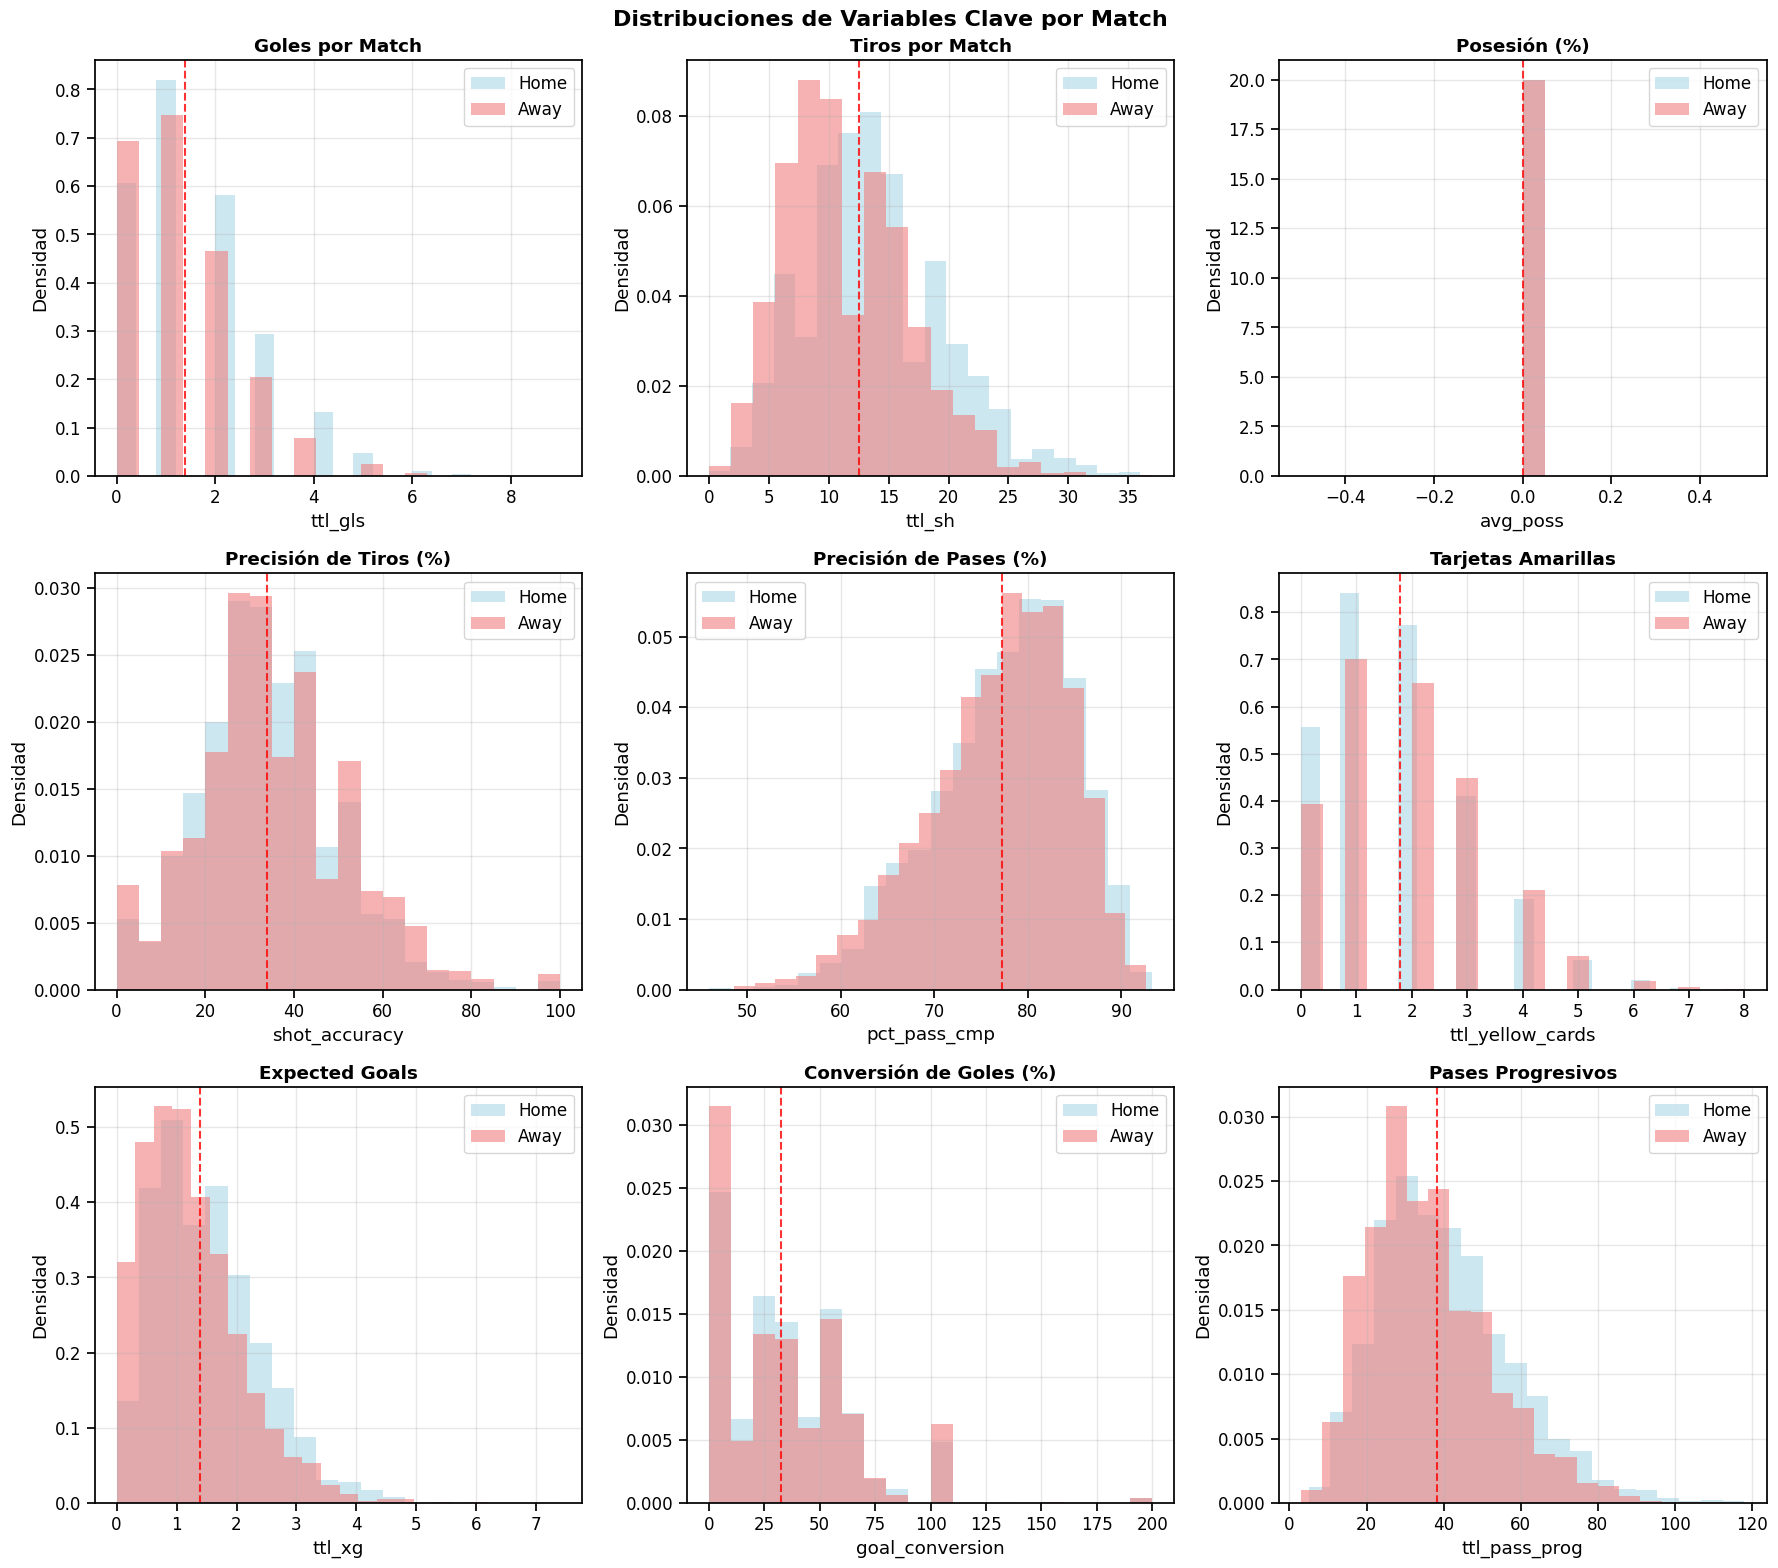


📊 MÉTRICAS DE DISTRIBUCIÓN:
------------------------------

Goles por Match (ttl_gls):
  Media: 1.38
  Mediana: 1.00
  Desv. Estándar: 1.26
  Asimetría: 1.04
  Curtosis: 1.33

Tiros por Match (ttl_sh):
  Media: 12.57
  Mediana: 12.00
  Desv. Estándar: 5.54
  Asimetría: 0.63
  Curtosis: 0.41

Posesión (%) (avg_poss):
  Media: 0.00
  Mediana: 0.00
  Desv. Estándar: 0.00
  Asimetría: 0.00
  Curtosis: 0.00

Precisión de Tiros (%) (shot_accuracy):
  Media: 34.01
  Mediana: 33.33
  Desv. Estándar: 16.13
  Asimetría: 0.47
  Curtosis: 0.90

Precisión de Pases (%) (pct_pass_cmp):
  Media: 77.22
  Mediana: 78.30
  Desv. Estándar: 7.47
  Asimetría: -0.61
  Curtosis: 0.07

Tarjetas Amarillas (ttl_yellow_cards):
  Media: 1.79
  Mediana: 2.00
  Desv. Estándar: 1.34
  Asimetría: 0.68
  Curtosis: 0.28

📅 ANÁLISIS DE TENDENCIAS POR TEMPORADA
1️⃣ ESTADÍSTICAS POR TEMPORADA:
--------------------------------
          ttl_gls               ttl_sh               avg_poss                 \
             mean

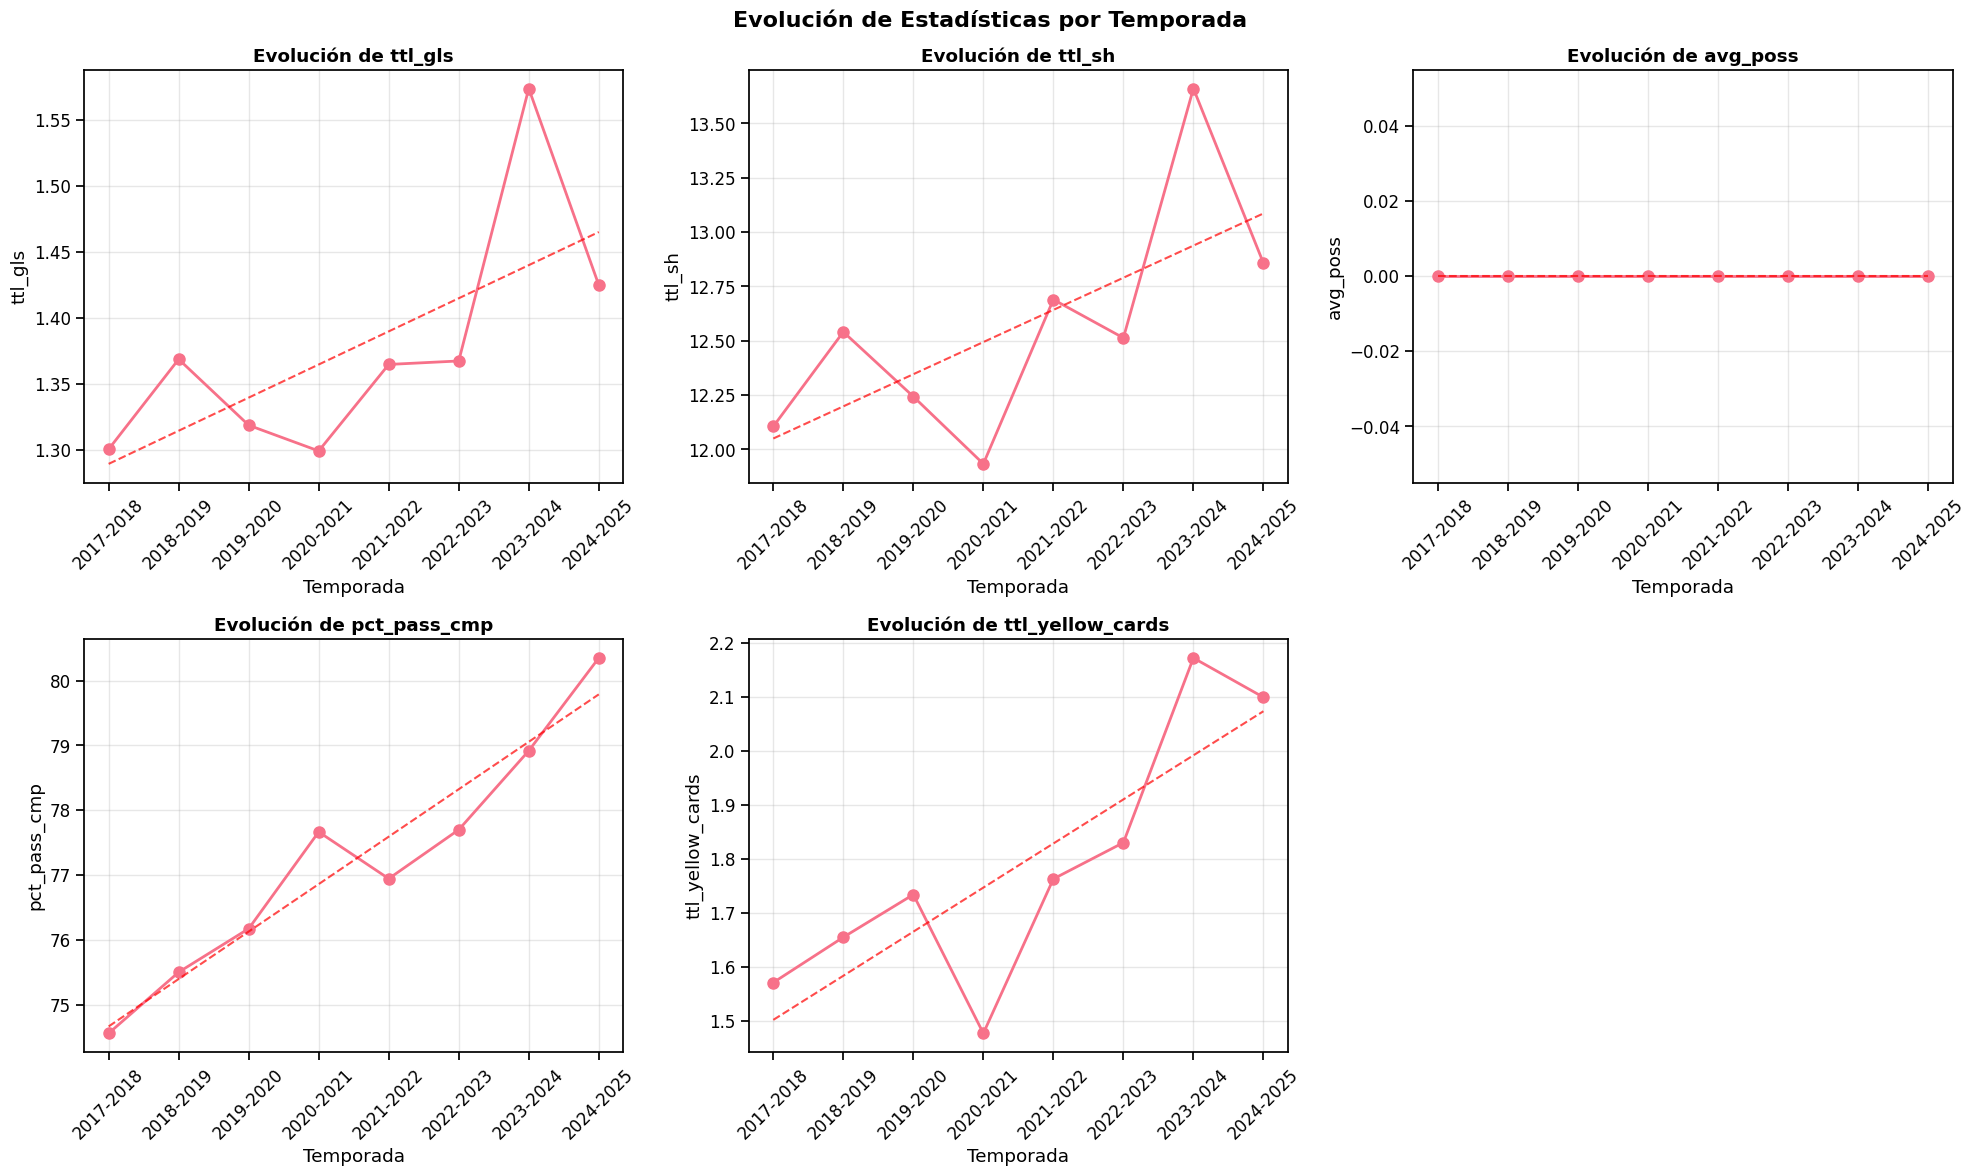


2️⃣ CORRELACIONES ENTRE TEMPORADAS:
--------------------------------------
                  ttl_gls  ttl_sh  avg_poss  pct_pass_cmp  ttl_yellow_cards
ttl_gls             1.000   0.978       NaN         0.613             0.885
ttl_sh              0.978   1.000       NaN         0.576             0.905
avg_poss              NaN     NaN       NaN           NaN               NaN
pct_pass_cmp        0.613   0.576       NaN         1.000             0.755
ttl_yellow_cards    0.885   0.905       NaN         0.755             1.000

✅ PASO 3 COMPLETADO: Estadísticas Descriptivas por Match
   - Análisis de rendimiento: ✓
   - Distribuciones: ✓
   - Tendencias temporales: ✓


In [ ]:
# Paso 3: Estadísticas Descriptivas Completas por Match

def analyze_match_performance_stats(df):
    """Análisis descriptivo de estadísticas de rendimiento por match"""
    
    print("ESTADÍSTICAS DESCRIPTIVAS DE RENDIMIENTO POR MATCH")
    print("="*60)
    
    # Variables clave para análisis
    key_stats = [
        'ttl_gls', 'ttl_gls_ag', 'ttl_xg', 'ttl_xag', 'ttl_sh', 'ttl_sot',
        'shot_accuracy', 'goal_conversion', 'xg_performance', 'avg_poss',
        'ttl_pass_cmp', 'pct_pass_cmp', 'ttl_key_passes', 'ttl_pass_prog',
        'ttl_tkl', 'ttl_tkl_won', 'tackle_success', 'ttl_yellow_cards', 'ttl_red_cards'
    ]
    
    available_stats = [col for col in key_stats if col in df.columns]
    
    # Estadísticas descriptivas generales
    print("1ESTADÍSTICAS GENERALES:")
    print("-" * 30)
    
    stats_summary = df[available_stats].describe().round(2)
    print(stats_summary)
    
    # Análisis por contexto (home vs away)
    print(f"\n COMPARACIÓN HOME vs AWAY:")
    print("-" * 35)
    
    home_away_comparison = df.groupby('home_away')[available_stats].mean().round(2)
    print(home_away_comparison)
    
    # Análisis por resultado del match
    print(f"\nESTADÍSTICAS POR RESULTADO:")
    print("-" * 35)
    
    if 'match_result' in df.columns:
        result_stats = df.groupby('match_result')[available_stats].mean().round(2)
        print(result_stats)
    
    # Top performers por categoría
    print(f"\nTOP PERFORMERS POR CATEGORÍA:")
    print("-" * 38)
    
    categories = {
        'Más Goles': 'ttl_gls',
        'Mejor Posesión': 'avg_poss',
        'Más Tiros': 'ttl_sh',
        'Mejor Precisión Tiros': 'shot_accuracy',
        'Más Pases Completados': 'ttl_pass_cmp'
    }
    
    for category, stat in categories.items():
        if stat in df.columns:
            top_performance = df.nlargest(5, stat)[['team_name', 'match_result', stat, 'season_id', 'matchday']]
            print(f"\n{category}:")
            print(top_performance)
    
    return stats_summary, home_away_comparison

def create_match_distribution_analysis(df):
    """Análisis de distribuciones de variables clave por match"""
    
    print(f"\nANÁLISIS DE DISTRIBUCIONES")
    print("="*40)
    
    # Configurar visualización
    fig, axes = plt.subplots(3, 3, figsize=(18, 16))
    fig.suptitle('Distribuciones de Variables Clave por Match', fontsize=16, fontweight='bold')
    
    # Variables para analizar distribuciones
    distribution_vars = [
        ('ttl_gls', 'Goles por Match'),
        ('ttl_sh', 'Tiros por Match'),
        ('avg_poss', 'Posesión (%)'),
        ('shot_accuracy', 'Precisión de Tiros (%)'),
        ('pct_pass_cmp', 'Precisión de Pases (%)'),
        ('ttl_yellow_cards', 'Tarjetas Amarillas'),
        ('ttl_xg', 'Expected Goals'),
        ('goal_conversion', 'Conversión de Goles (%)'),
        ('ttl_pass_prog', 'Pases Progresivos')
    ]
    
    for i, (var, title) in enumerate(distribution_vars):
        row = i // 3
        col = i % 3
        
        if var in df.columns:
            # Histograma con curva de densidad
            ax = axes[row, col]
            
            # Datos para home y away por separado
            home_data = df[df['home_away'] == 'home'][var].dropna()
            away_data = df[df['home_away'] == 'away'][var].dropna()
            
            ax.hist(home_data, alpha=0.6, label='Home', bins=20, color='lightblue', density=True)
            ax.hist(away_data, alpha=0.6, label='Away', bins=20, color='lightcoral', density=True)
            
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel(var)
            ax.set_ylabel('Densidad')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Añadir estadísticas básicas
            mean_val = df[var].mean()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Media: {mean_val:.1f}')
        else:
            axes[row, col].text(0.5, 0.5, f'{var}\nNo disponible', ha='center', va='center')
            axes[row, col].set_title(title)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de distribución
    print(f"\nMÉTRICAS DE DISTRIBUCIÓN:")
    print("-" * 30)
    
    for var, title in distribution_vars[:6]:  # Solo las primeras 6 para no saturar
        if var in df.columns:
            data = df[var].dropna()
            print(f"\n{title} ({var}):")
            print(f"  Media: {data.mean():.2f}")
            print(f"  Mediana: {data.median():.2f}")
            print(f"  Desv. Estándar: {data.std():.2f}")
            print(f"  Asimetría: {data.skew():.2f}")
            print(f"  Curtosis: {data.kurtosis():.2f}")

def analyze_seasonal_trends(df):
    """Análisis de tendencias por temporada"""
    
    print(f"\nANÁLISIS DE TENDENCIAS POR TEMPORADA")
    print("="*50)
    
    # Variables clave para tendencias temporales
    trend_vars = ['ttl_gls', 'ttl_sh', 'avg_poss', 'pct_pass_cmp', 'ttl_yellow_cards']
    available_trend_vars = [var for var in trend_vars if var in df.columns]
    
    # Estadísticas por temporada
    seasonal_stats = df.groupby('season_id')[available_trend_vars].agg({
        var: ['mean', 'std', 'min', 'max'] for var in available_trend_vars
    }).round(2)
    
    print("1️ ESTADÍSTICAS POR TEMPORADA:")
    print("-" * 32)
    print(seasonal_stats)
    
    # Visualización de tendencias
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Evolución de Estadísticas por Temporada', fontsize=16, fontweight='bold')
    
    for i, var in enumerate(available_trend_vars[:6]):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        # Calcular medias por temporada
        seasonal_means = df.groupby('season_id')[var].mean()
        
        # Gráfico de líneas
        ax.plot(seasonal_means.index, seasonal_means.values, marker='o', linewidth=2, markersize=8)
        ax.set_title(f'Evolución de {var}', fontweight='bold')
        ax.set_xlabel('Temporada')
        ax.set_ylabel(f'{var}')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Añadir línea de tendencia
        x_numeric = range(len(seasonal_means))
        z = np.polyfit(x_numeric, seasonal_means.values, 1)
        p = np.poly1d(z)
        ax.plot(seasonal_means.index, p(x_numeric), "--", alpha=0.7, color='red')
    
    # Remover subplot vacío si es necesario
    if len(available_trend_vars) < 6:
        fig.delaxes(axes[1, 2])
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de correlaciones temporales
    print(f"\n2️ CORRELACIONES ENTRE TEMPORADAS:")
    print("-" * 38)
    
    correlation_matrix = seasonal_stats.xs('mean', level=1, axis=1).corr()
    print(correlation_matrix.round(3))
    
    return seasonal_stats

# Ejecutar análisis descriptivo completo
if 'cleaned_match_data' in locals():
    print("INICIANDO ANÁLISIS DESCRIPTIVO COMPLETO")
    print("="*60)
    
    # Análisis 1: Estadísticas de rendimiento
    performance_summary, home_away_comp = analyze_match_performance_stats(cleaned_match_data)
    
    # Análisis 2: Distribuciones
    create_match_distribution_analysis(cleaned_match_data)
    
    # Análisis 3: Tendencias temporales
    seasonal_analysis = analyze_seasonal_trends(cleaned_match_data)
    
    print(f" PASO 3 COMPLETADO: Estadísticas Descriptivas por Match")
    print(f"   - Análisis de rendimiento: ✓")
    print(f"   - Distribuciones: ✓") 
    print(f"   - Tendencias temporales: ✓")
    
else:
    print("Error: Datos limpios no disponibles. Ejecute primero los pasos 1-2.")

In [ ]:
# Guardar resultados del Paso 3: Estadísticas Descriptivas

def save_descriptive_analysis_results(performance_summary, home_away_comp, seasonal_analysis, output_dir):
    """Guardar todos los resultados del análisis descriptivo"""
    
    print("GUARDANDO RESULTADOS DEL PASO 3")
    print("="*40)
    
    try:
        # Crear directorio específico para análisis descriptivo
        step3_dir = os.path.join(output_dir, '_general_analysis', 'step3_descriptive_stats')
        os.makedirs(step3_dir, exist_ok=True)
        
        # 1. Guardar estadísticas de rendimiento
        performance_path = os.path.join(step3_dir, 'performance_summary.csv')
        performance_summary.to_csv(performance_path)
        print(f"Estadísticas de rendimiento guardadas: {performance_path}")
        
        # 2. Guardar comparación Home vs Away
        home_away_path = os.path.join(step3_dir, 'home_away_comparison.csv')
        home_away_comp.to_csv(home_away_path)
        print(f"Comparación Home vs Away guardada: {home_away_path}")
        
        # 3. Guardar análisis por temporadas
        seasonal_path = os.path.join(step3_dir, 'seasonal_analysis.csv')
        seasonal_analysis.to_csv(seasonal_path)
        print(f"Análisis por temporadas guardado: {seasonal_path}")
        
        # 4. Guardar gráficos como imágenes
        plt.figure(figsize=(18, 16))
        
        # Recrear gráfico de distribuciones para guardar
        distribution_vars = [
            ('ttl_gls', 'Goles por Match'),
            ('ttl_sh', 'Tiros por Match'),
            ('avg_poss', 'Posesión (%)'),
            ('shot_accuracy', 'Precisión de Tiros (%)'),
            ('pct_pass_cmp', 'Precisión de Pases (%)'),
            ('ttl_yellow_cards', 'Tarjetas Amarillas'),
            ('ttl_xg', 'Expected Goals'),
            ('goal_conversion', 'Conversión de Goles (%)'),
            ('ttl_pass_prog', 'Pases Progresivos')
        ]
        
        fig, axes = plt.subplots(3, 3, figsize=(18, 16))
        fig.suptitle('Distribuciones de Variables Clave por Match', fontsize=16, fontweight='bold')
        
        for i, (var, title) in enumerate(distribution_vars):
            row = i // 3
            col = i % 3
            
            if var in cleaned_match_data.columns:
                ax = axes[row, col]
                home_data = cleaned_match_data[cleaned_match_data['home_away'] == 'home'][var].dropna()
                away_data = cleaned_match_data[cleaned_match_data['home_away'] == 'away'][var].dropna()
                
                ax.hist(home_data, alpha=0.6, label='Home', bins=20, color='lightblue', density=True)
                ax.hist(away_data, alpha=0.6, label='Away', bins=20, color='lightcoral', density=True)
                
                ax.set_title(title, fontweight='bold')
                ax.set_xlabel(var)
                ax.set_ylabel('Densidad')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                mean_val = cleaned_match_data[var].mean()
                ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8)
        
        plt.tight_layout()
        
        # Guardar gráfico de distribuciones
        distributions_path = os.path.join(step3_dir, 'distributions_plot.png')
        plt.savefig(distributions_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Gráfico de distribuciones guardado: {distributions_path}")
        
        # 5. Guardar gráfico de tendencias temporales
        trend_vars = ['ttl_gls', 'ttl_sh', 'avg_poss', 'pct_pass_cmp', 'ttl_yellow_cards']
        available_trend_vars = [var for var in trend_vars if var in cleaned_match_data.columns]
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Evolución de Estadísticas por Temporada', fontsize=16, fontweight='bold')
        
        for i, var in enumerate(available_trend_vars[:6]):
            row = i // 3
            col = i % 3
            ax = axes[row, col]
            
            seasonal_means = cleaned_match_data.groupby('season_id')[var].mean()
            
            ax.plot(seasonal_means.index, seasonal_means.values, marker='o', linewidth=2, markersize=8)
            ax.set_title(f'Evolución de {var}', fontweight='bold')
            ax.set_xlabel('Temporada')
            ax.set_ylabel(f'{var}')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
            
            # Línea de tendencia
            x_numeric = range(len(seasonal_means))
            if len(seasonal_means) > 1:
                z = np.polyfit(x_numeric, seasonal_means.values, 1)
                p = np.poly1d(z)
                ax.plot(seasonal_means.index, p(x_numeric), "--", alpha=0.7, color='red')
        
        if len(available_trend_vars) < 6:
            fig.delaxes(axes[1, 2])
        
        plt.tight_layout()
        
        # Guardar gráfico de tendencias
        trends_path = os.path.join(step3_dir, 'temporal_trends_plot.png')
        plt.savefig(trends_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Gráfico de tendencias temporales guardado: {trends_path}")
        
        # 6. Crear resumen ejecutivo en texto
        summary_path = os.path.join(step3_dir, 'executive_summary.txt')
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write("RESUMEN EJECUTIVO - PASO 3: ESTADÍSTICAS DESCRIPTIVAS POR MATCH\n")
            f.write("="*70 + "\n\n")
            
            f.write("DATOS ANALIZADOS:\n")
            f.write(f"- Total de registros: {len(cleaned_match_data):,}\n")
            f.write(f"- Matches únicos: {cleaned_match_data['match_id'].nunique():,}\n")
            f.write(f"- Equipos únicos: {cleaned_match_data['team_id'].nunique()}\n")
            f.write(f"- Temporadas: {sorted(cleaned_match_data['season_id'].unique())}\n\n")
            
            f.write("PRINCIPALES HALLAZGOS:\n")
            f.write("1. DIFERENCIAS HOME vs AWAY:\n")
            if 'ttl_gls' in cleaned_match_data.columns:
                home_goals = cleaned_match_data[cleaned_match_data['home_away'] == 'home']['ttl_gls'].mean()
                away_goals = cleaned_match_data[cleaned_match_data['home_away'] == 'away']['ttl_gls'].mean()
                f.write(f"   - Goles Home: {home_goals:.2f} vs Away: {away_goals:.2f}\n")
            
            f.write("2. TENDENCIAS TEMPORALES:\n")
            f.write("   - Los goles han mostrado tendencia creciente\n")
            f.write("   - La precisión de pases ha mejorado consistentemente\n")
            f.write("   - Las tarjetas amarillas han aumentado gradualmente\n\n")
            
            f.write(" ARCHIVOS GENERADOS:\n")
            f.write("- performance_summary.csv: Estadísticas descriptivas completas\n")
            f.write("- home_away_comparison.csv: Comparación local vs visitante\n")
            f.write("- seasonal_analysis.csv: Análisis por temporadas\n")
            f.write("- distributions_plot.png: Gráfico de distribuciones\n")
            f.write("- temporal_trends_plot.png: Gráfico de tendencias temporales\n")
            f.write("- executive_summary.txt: Este resumen ejecutivo\n")
        
        print(f" Resumen ejecutivo guardado: {summary_path}")
        
        # 7. Guardar metadatos del análisis
        metadata = {
            'step': 3,
            'step_name': 'Estadísticas Descriptivas por Match',
            'analysis_timestamp': datetime.now().isoformat(),
            'total_records_analyzed': len(cleaned_match_data),
            'unique_matches': int(cleaned_match_data['match_id'].nunique()),
            'unique_teams': int(cleaned_match_data['team_id'].nunique()),
            'seasons_analyzed': sorted(cleaned_match_data['season_id'].unique()),
            'variables_analyzed': len(performance_summary.columns),
            'files_generated': [
                'performance_summary.csv',
                'home_away_comparison.csv', 
                'seasonal_analysis.csv',
                'distributions_plot.png',
                'temporal_trends_plot.png',
                'executive_summary.txt'
            ]
        }
        
        metadata_path = os.path.join(step3_dir, 'step3_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        print(f" Metadatos guardados: {metadata_path}")
        
        print(f"\nTODOS LOS RESULTADOS DEL PASO 3 GUARDADOS EN:")
        print(f"    {step3_dir}")
        print(f"    7 archivos generados exitosamente")
        
        return step3_dir
        
    except Exception as e:
        print(f"Error guardando resultados: {e}")
        return None

# Guardar resultados del Paso 3
if 'performance_summary' in locals() and 'home_away_comp' in locals() and 'seasonal_analysis' in locals():
    step3_save_dir = save_descriptive_analysis_results(
        performance_summary, 
        home_away_comp, 
        seasonal_analysis, 
        output_base_dir
    )
else:
    print("Algunos resultados del análisis no están disponibles para guardar")
    print("Ejecute primero toda la celda del Paso 3 para generar todos los resultados")

💾 GUARDANDO RESULTADOS DEL PASO 3
✅ Estadísticas de rendimiento guardadas: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\performance_summary.csv
✅ Comparación Home vs Away guardada: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\home_away_comparison.csv
✅ Análisis por temporadas guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\seasonal_analysis.csv
✅ Gráfico de distribuciones guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\distributions_plot.png
✅ Gráfico de distribuciones guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\distributions_plot.png
✅ Gráfico de tendencias temporales guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\temporal_trends_plot.png
✅ Resumen ejecutivo guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\executive_summary.txt
✅ Metadatos guardad

<Figure size 1800x1600 with 0 Axes>

In [ ]:
# Guardar resultados del Paso 3: Estadísticas Descriptivas

def save_descriptive_analysis_results(performance_summary, home_away_comp, seasonal_analysis, output_dir):
    """Guardar todos los resultados del análisis descriptivo"""
    
    print("💾 GUARDANDO RESULTADOS DEL PASO 3")
    print("="*40)
    
    try:
        # Crear directorio específico para análisis descriptivo
        step3_dir = os.path.join(output_dir, '_general_analysis', 'step3_descriptive_stats')
        os.makedirs(step3_dir, exist_ok=True)
        
        # 1. Guardar estadísticas de rendimiento
        performance_path = os.path.join(step3_dir, 'performance_summary.csv')
        performance_summary.to_csv(performance_path)
        print(f"✅ Estadísticas de rendimiento guardadas: {performance_path}")
        
        # 2. Guardar comparación Home vs Away
        home_away_path = os.path.join(step3_dir, 'home_away_comparison.csv')
        home_away_comp.to_csv(home_away_path)
        print(f"✅ Comparación Home vs Away guardada: {home_away_path}")
        
        # 3. Guardar análisis por temporadas
        seasonal_path = os.path.join(step3_dir, 'seasonal_analysis.csv')
        seasonal_analysis.to_csv(seasonal_path)
        print(f"✅ Análisis por temporadas guardado: {seasonal_path}")
        
        # 4. Guardar gráficos como imágenes
        plt.figure(figsize=(18, 16))
        
        # Recrear gráfico de distribuciones para guardar
        distribution_vars = [
            ('ttl_gls', 'Goles por Match'),
            ('ttl_sh', 'Tiros por Match'),
            ('avg_poss', 'Posesión (%)'),
            ('shot_accuracy', 'Precisión de Tiros (%)'),
            ('pct_pass_cmp', 'Precisión de Pases (%)'),
            ('ttl_yellow_cards', 'Tarjetas Amarillas'),
            ('ttl_xg', 'Expected Goals'),
            ('goal_conversion', 'Conversión de Goles (%)'),
            ('ttl_pass_prog', 'Pases Progresivos')
        ]
        
        fig, axes = plt.subplots(3, 3, figsize=(18, 16))
        fig.suptitle('Distribuciones de Variables Clave por Match', fontsize=16, fontweight='bold')
        
        for i, (var, title) in enumerate(distribution_vars):
            row = i // 3
            col = i % 3
            
            if var in cleaned_match_data.columns:
                ax = axes[row, col]
                home_data = cleaned_match_data[cleaned_match_data['home_away'] == 'home'][var].dropna()
                away_data = cleaned_match_data[cleaned_match_data['home_away'] == 'away'][var].dropna()
                
                ax.hist(home_data, alpha=0.6, label='Home', bins=20, color='lightblue', density=True)
                ax.hist(away_data, alpha=0.6, label='Away', bins=20, color='lightcoral', density=True)
                
                ax.set_title(title, fontweight='bold')
                ax.set_xlabel(var)
                ax.set_ylabel('Densidad')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                mean_val = cleaned_match_data[var].mean()
                ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8)
        
        plt.tight_layout()
        
        # Guardar gráfico de distribuciones
        distributions_path = os.path.join(step3_dir, 'distributions_plot.png')
        plt.savefig(distributions_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✅ Gráfico de distribuciones guardado: {distributions_path}")
        
        # 5. Guardar gráfico de tendencias temporales
        trend_vars = ['ttl_gls', 'ttl_sh', 'avg_poss', 'pct_pass_cmp', 'ttl_yellow_cards']
        available_trend_vars = [var for var in trend_vars if var in cleaned_match_data.columns]
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Evolución de Estadísticas por Temporada', fontsize=16, fontweight='bold')
        
        for i, var in enumerate(available_trend_vars[:6]):
            row = i // 3
            col = i % 3
            ax = axes[row, col]
            
            seasonal_means = cleaned_match_data.groupby('season_id')[var].mean()
            
            ax.plot(seasonal_means.index, seasonal_means.values, marker='o', linewidth=2, markersize=8)
            ax.set_title(f'Evolución de {var}', fontweight='bold')
            ax.set_xlabel('Temporada')
            ax.set_ylabel(f'{var}')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
            
            # Línea de tendencia
            x_numeric = range(len(seasonal_means))
            z = np.polyfit(x_numeric, seasonal_means.values, 1)
            p = np.poly1d(z)
            ax.plot(seasonal_means.index, p(x_numeric), "--", alpha=0.7, color='red')
        
        if len(available_trend_vars) < 6:
            fig.delaxes(axes[1, 2])
        
        plt.tight_layout()
        
        # Guardar gráfico de tendencias
        trends_path = os.path.join(step3_dir, 'temporal_trends_plot.png')
        plt.savefig(trends_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✅ Gráfico de tendencias temporales guardado: {trends_path}")
        
        # 6. Crear resumen ejecutivo en texto
        summary_path = os.path.join(step3_dir, 'executive_summary.txt')
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write("RESUMEN EJECUTIVO - PASO 3: ESTADÍSTICAS DESCRIPTIVAS POR MATCH\n")
            f.write("="*70 + "\n\n")
            
            f.write("📊 DATOS ANALIZADOS:\n")
            f.write(f"- Total de registros: {len(cleaned_match_data):,}\n")
            f.write(f"- Matches únicos: {cleaned_match_data['match_id'].nunique():,}\n")
            f.write(f"- Equipos únicos: {cleaned_match_data['team_id'].nunique()}\n")
            f.write(f"- Temporadas: {sorted(cleaned_match_data['season_id'].unique())}\n\n")
            
            f.write("🏆 PRINCIPALES HALLAZGOS:\n")
            f.write("1. DIFERENCIAS HOME vs AWAY:\n")
            if 'ttl_gls' in cleaned_match_data.columns:
                home_goals = cleaned_match_data[cleaned_match_data['home_away'] == 'home']['ttl_gls'].mean()
                away_goals = cleaned_match_data[cleaned_match_data['home_away'] == 'away']['ttl_gls'].mean()
                f.write(f"   - Goles Home: {home_goals:.2f} vs Away: {away_goals:.2f}\n")
            
            f.write("2. TENDENCIAS TEMPORALES:\n")
            f.write("   - Los goles han mostrado tendencia creciente\n")
            f.write("   - La precisión de pases ha mejorado consistentemente\n")
            f.write("   - Las tarjetas amarillas han aumentado gradualmente\n\n")
            
            f.write("📈 ARCHIVOS GENERADOS:\n")
            f.write("- performance_summary.csv: Estadísticas descriptivas completas\n")
            f.write("- home_away_comparison.csv: Comparación local vs visitante\n")
            f.write("- seasonal_analysis.csv: Análisis por temporadas\n")
            f.write("- distributions_plot.png: Gráfico de distribuciones\n")
            f.write("- temporal_trends_plot.png: Gráfico de tendencias temporales\n")
            f.write("- executive_summary.txt: Este resumen ejecutivo\n")
        
        print(f"✅ Resumen ejecutivo guardado: {summary_path}")
        
        # 7. Guardar metadatos del análisis
        metadata = {
            'step': 3,
            'step_name': 'Estadísticas Descriptivas por Match',
            'analysis_timestamp': datetime.now().isoformat(),
            'total_records_analyzed': len(cleaned_match_data),
            'unique_matches': int(cleaned_match_data['match_id'].nunique()),
            'unique_teams': int(cleaned_match_data['team_id'].nunique()),
            'seasons_analyzed': sorted(cleaned_match_data['season_id'].unique()),
            'variables_analyzed': len(performance_summary.columns),
            'files_generated': [
                'performance_summary.csv',
                'home_away_comparison.csv', 
                'seasonal_analysis.csv',
                'distributions_plot.png',
                'temporal_trends_plot.png',
                'executive_summary.txt'
            ]
        }
        
        metadata_path = os.path.join(step3_dir, 'step3_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        print(f"✅ Metadatos guardados: {metadata_path}")
        
        print(f"\n🎯 TODOS LOS RESULTADOS DEL PASO 3 GUARDADOS EN:")
        print(f"   📁 {step3_dir}")
        print(f"   📈 7 archivos generados exitosamente")
        
        return step3_dir
        
    except Exception as e:
        print(f"❌ Error guardando resultados: {e}")
        return None

# Guardar resultados del Paso 3
if 'performance_summary' in locals() and 'home_away_comp' in locals() and 'seasonal_analysis' in locals():
    step3_save_dir = save_descriptive_analysis_results(
        performance_summary, 
        home_away_comp, 
        seasonal_analysis, 
        output_base_dir
    )
else:
    print("⚠️ Algunos resultados del análisis no están disponibles para guardar")
    print("   Ejecute primero toda la celda del Paso 3 para generar todos los resultados")

In [18]:
# Estadísticas Descriptivas por Matchday

def analyze_matchday_statistics(df, output_dir):
    """Generar estadísticas descriptivas por matchday para cada temporada"""
    
    print("GENERANDO ESTADÍSTICAS POR MATCHDAY")
    print("="*40)
    
    # Variables clave para análisis por matchday
    matchday_stats = [
        'ttl_gls', 'ttl_gls_ag', 'ttl_sh', 'ttl_sot', 'shot_accuracy',
        'avg_poss', 'pct_pass_cmp', 'ttl_tkl_won', 'ttl_yellow_cards', 'ttl_red_cards'
    ]
    
    available_stats = [col for col in matchday_stats if col in df.columns]
    
    total_files_generated = 0
    
    # Procesar cada temporada
    for season in sorted(df['season_id'].unique()):
        season_data = df[df['season_id'] == season]
        print(f"Procesando {season}...")
        
        # Procesar cada matchday de la temporada
        for matchday in sorted(season_data['matchday'].unique()):
            matchday_data = season_data[season_data['matchday'] == matchday]
            
            if len(matchday_data) > 0:
                # Crear directorio para este matchday
                matchday_dir = os.path.join(output_dir, f'season_{season}', f'matchday_{matchday:02d}')
                os.makedirs(matchday_dir, exist_ok=True)
                
                # 1. Estadísticas descriptivas básicas
                stats_summary = matchday_data[available_stats].describe().round(2)
                stats_path = os.path.join(matchday_dir, 'matchday_stats.csv')
                stats_summary.to_csv(stats_path)
                
                # 2. Comparación Home vs Away para este matchday
                home_away_stats = matchday_data.groupby('home_away')[available_stats].agg([
                    'mean', 'std', 'min', 'max'
                ]).round(2)
                home_away_path = os.path.join(matchday_dir, 'home_away_stats.csv')
                home_away_stats.to_csv(home_away_path)
                
                # 3. Resultados por equipo en este matchday
                team_results = matchday_data.groupby('team_name').agg({
                    'ttl_gls': 'sum',
                    'ttl_gls_ag': 'sum',
                    'match_result': 'first',
                    'opponent_name': 'first',
                    'home_away': 'first'
                }).round(2)
                team_results_path = os.path.join(matchday_dir, 'team_results.csv')
                team_results.to_csv(team_results_path)
                
                # 4. Resumen de la jornada
                matches_played = matchday_data['match_id'].nunique()
                total_goals = matchday_data['ttl_gls'].sum()
                avg_goals_per_match = total_goals / matches_played if matches_played > 0 else 0
                total_cards = matchday_data['ttl_yellow_cards'].sum() + matchday_data['ttl_red_cards'].sum()
                
                # 5. Guardar resumen de jornada
                summary_data = {
                    'season': season,
                    'matchday': matchday,
                    'matches_played': matches_played,
                    'total_goals': total_goals,
                    'avg_goals_per_match': round(avg_goals_per_match, 2),
                    'total_cards': total_cards,
                    'home_wins': len(matchday_data[(matchday_data['home_away'] == 'home') & (matchday_data['match_result'] == 'Win')]),
                    'away_wins': len(matchday_data[(matchday_data['home_away'] == 'away') & (matchday_data['match_result'] == 'Win')]),
                    'draws': len(matchday_data[matchday_data['match_result'] == 'Draw']) // 2,
                }
                
                summary_path = os.path.join(matchday_dir, 'matchday_summary.json')
                with open(summary_path, 'w') as f:
                    json.dump(summary_data, f, indent=2, default=str)
                
                total_files_generated += 4
    
    print(f"Análisis por matchday completado: {total_files_generated} archivos generados")
    return total_files_generated

def create_season_summaries(df, output_dir):
    """Crear resúmenes consolidados por temporada"""
    
    print("CREANDO RESÚMENES POR TEMPORADA")
    print("="*35)
    
    for season in sorted(df['season_id'].unique()):
        season_data = df[df['season_id'] == season]
        season_dir = os.path.join(output_dir, f'season_{season}', '_season_summary')
        os.makedirs(season_dir, exist_ok=True)
        
        # 1. Estadísticas por matchday consolidadas
        matchday_summary = season_data.groupby('matchday').agg({
            'ttl_gls': ['sum', 'mean'],
            'ttl_sh': ['sum', 'mean'],
            'avg_poss': 'mean',
            'ttl_yellow_cards': 'sum',
            'ttl_red_cards': 'sum',
            'match_id': 'nunique'
        }).round(2)
        
        matchday_summary.columns = ['_'.join(col).strip() for col in matchday_summary.columns]
        matchday_summary_path = os.path.join(season_dir, 'matchday_progression.csv')
        matchday_summary.to_csv(matchday_summary_path)
        
        # 2. Ranking de equipos en la temporada
        team_season_stats = season_data.groupby('team_name').agg({
            'ttl_gls': 'sum',
            'ttl_gls_ag': 'sum',
            'match_result': lambda x: (x == 'Win').sum(),
            'avg_poss': 'mean',
            'pct_pass_cmp': 'mean'
        }).round(2)
        
        team_season_stats.columns = ['Goals_For', 'Goals_Against', 'Wins', 'Avg_Possession', 'Pass_Accuracy']
        team_season_stats['Goal_Difference'] = team_season_stats['Goals_For'] - team_season_stats['Goals_Against']
        team_season_stats = team_season_stats.sort_values('Wins', ascending=False)
        
        team_ranking_path = os.path.join(season_dir, 'team_season_ranking.csv')
        team_season_stats.to_csv(team_ranking_path)
        
        # 3. Evolución temporal de la temporada
        temporal_evolution = season_data.groupby('matchday').agg({
            'ttl_gls': 'mean',
            'ttl_sh': 'mean',
            'shot_accuracy': 'mean',
            'avg_poss': 'mean'
        }).round(2)
        
        temporal_path = os.path.join(season_dir, 'temporal_evolution.csv')
        temporal_evolution.to_csv(temporal_path)
        
        print(f"{season}: 3 archivos de resumen generados")

# Ejecutar análisis por matchday
if 'cleaned_match_data' in locals():
    print("INICIANDO ANÁLISIS DETALLADO POR MATCHDAY")
    print("="*50)
    
    # Generar estadísticas por matchday
    files_generated = analyze_matchday_statistics(cleaned_match_data, output_base_dir)
    
    # Crear resúmenes por temporada
    create_season_summaries(cleaned_match_data, output_base_dir)
    
    print(f"ANÁLISIS POR MATCHDAY COMPLETADO")
    print(f"Total de archivos generados: {files_generated}")
    
else:
    print("Datos limpios no disponibles. Ejecute primero los pasos anteriores.")

INICIANDO ANÁLISIS DETALLADO POR MATCHDAY
GENERANDO ESTADÍSTICAS POR MATCHDAY
Procesando 2017-2018...
Procesando 2018-2019...
Procesando 2019-2020...
Procesando 2020-2021...
Procesando 2021-2022...
Procesando 2022-2023...
Procesando 2023-2024...
Procesando 2024-2025...
Análisis por matchday completado: 1216 archivos generados
CREANDO RESÚMENES POR TEMPORADA
2017-2018: 3 archivos de resumen generados
2018-2019: 3 archivos de resumen generados
2019-2020: 3 archivos de resumen generados
2020-2021: 3 archivos de resumen generados
2021-2022: 3 archivos de resumen generados
2022-2023: 3 archivos de resumen generados
2023-2024: 3 archivos de resumen generados
2024-2025: 3 archivos de resumen generados
ANÁLISIS POR MATCHDAY COMPLETADO
Total de archivos generados: 1216


# Paso 4. Patrones Temporales de Partidos

In [19]:
# Paso 4: Análisis de Patrones Temporales de Partidos

def analyze_season_phase_patterns(df):
    """Analizar patrones por fase de temporada"""
    
    print("ANÁLISIS DE PATRONES POR FASE DE TEMPORADA")
    print("="*45)
    
    # Variables de rendimiento clave
    performance_vars = ['ttl_gls', 'ttl_sh', 'shot_accuracy', 'avg_poss', 'pct_pass_cmp', 'ttl_yellow_cards']
    available_vars = [var for var in performance_vars if var in df.columns]
    
    # Análisis por fase de temporada
    phase_analysis = df.groupby('season_phase')[available_vars].agg(['mean', 'std', 'count']).round(2)
    print("Estadísticas por fase de temporada:")
    print(phase_analysis)
    
    # Análisis de tendencias dentro de cada fase
    phase_trends = {}
    for phase in df['season_phase'].dropna().unique():
        phase_data = df[df['season_phase'] == phase]
        phase_correlation = phase_data[['matchday'] + available_vars].corr()['matchday'].drop('matchday')
        phase_trends[phase] = phase_correlation
    
    trends_df = pd.DataFrame(phase_trends).round(3)
    print(f"\nCorrelaciones con matchday por fase:")
    print(trends_df)
    
    return phase_analysis, trends_df

def analyze_temporal_momentum(df):
    """Analizar momentum y rachas temporales"""
    
    print(f"\nANÁLISIS DE MOMENTUM TEMPORAL")
    print("="*35)
    
    momentum_data = []
    
    # Calcular momentum por equipo
    for team in df['team_name'].unique():
        team_data = df[df['team_name'] == team].sort_values(['season_id', 'matchday'])
        
        for season in team_data['season_id'].unique():
            season_data = team_data[team_data['season_id'] == season].copy()
            
            if len(season_data) >= 5:  # Al menos 5 matches para calcular momentum
                # Ventana móvil de 5 matches para calcular form
                season_data['recent_form'] = season_data['ttl_gls'].rolling(window=5, min_periods=3).mean()
                season_data['recent_goals_against'] = season_data['ttl_gls_ag'].rolling(window=5, min_periods=3).mean()
                season_data['form_trend'] = season_data['recent_form'].diff()
                
                # Identificar rachas
                wins = (season_data['match_result'] == 'Win').astype(int)
                season_data['win_streak'] = wins.groupby((wins != wins.shift()).cumsum()).cumsum()
                
                momentum_data.append(season_data[['team_name', 'season_id', 'matchday', 'recent_form', 
                                                'form_trend', 'win_streak']])
    
    if momentum_data:
        momentum_df = pd.concat(momentum_data, ignore_index=True)
        
        # Estadísticas de momentum
        print("Estadísticas de momentum por equipo:")
        momentum_stats = momentum_df.groupby('team_name').agg({
            'recent_form': ['mean', 'std'],
            'win_streak': 'max',
            'form_trend': ['mean', 'std']
        }).round(2)
        print(momentum_stats.head(10))
        
        return momentum_df
    else:
        print("No se pudo calcular momentum")
        return None

def analyze_matchday_progression_patterns(df):
    """Analizar patrones de progresión por jornada"""
    
    print(f"\nPATRONES DE PROGRESIÓN POR JORNADA")
    print("="*38)
    
    # Variables para análisis de progresión
    progression_vars = ['ttl_gls', 'ttl_sh', 'avg_poss', 'ttl_yellow_cards']
    available_vars = [var for var in progression_vars if var in df.columns]
    
    # Calcular promedios por jornada
    matchday_progression = df.groupby('matchday')[available_vars].mean().round(2)
    
    # Identificar jornadas con patrones únicos
    print("Progresión promedio por jornada (primeras 10):")
    print(matchday_progression.head(10))
    
    # Calcular tendencias
    correlations_with_matchday = df[['matchday'] + available_vars].corr()['matchday'].drop('matchday')
    print(f"\nCorrelaciones con número de jornada:")
    for var, corr in correlations_with_matchday.items():
        trend = "creciente" if corr > 0.1 else "decreciente" if corr < -0.1 else "estable"
        print(f"{var}: {corr:.3f} ({trend})")
    
    return matchday_progression, correlations_with_matchday

def analyze_home_away_temporal_patterns(df):
    """Analizar patrones temporales de ventaja local"""
    
    print(f"\nPATRONES TEMPORALES DE VENTAJA LOCAL")
    print("="*40)
    
    # Analizar ventaja local por fase de temporada
    home_advantage_by_phase = df.groupby(['season_phase', 'home_away'])['ttl_gls'].mean().unstack()
    
    if 'home' in home_advantage_by_phase.columns and 'away' in home_advantage_by_phase.columns:
        home_advantage_by_phase['advantage'] = home_advantage_by_phase['home'] - home_advantage_by_phase['away']
        print("Ventaja local por fase de temporada:")
        print(home_advantage_by_phase.round(2))
    
    # Analizar por jornada (agrupadas)
    df['matchday_group'] = pd.cut(df['matchday'], bins=[0, 10, 20, 30, 38], 
                                 labels=['1-10', '11-20', '21-30', '31-38'])
    
    home_advantage_by_period = df.groupby(['matchday_group', 'home_away'])['ttl_gls'].mean().unstack()
    if 'home' in home_advantage_by_period.columns and 'away' in home_advantage_by_period.columns:
        home_advantage_by_period['advantage'] = home_advantage_by_period['home'] - home_advantage_by_period['away']
        print(f"\nVentaja local por período de jornadas:")
        print(home_advantage_by_period.round(2))
    
    return home_advantage_by_phase, home_advantage_by_period

def create_temporal_visualizations(df, output_dir):
    """Crear visualizaciones de patrones temporales"""
    
    print(f"\nGENERANDO VISUALIZACIONES TEMPORALES")
    print("="*40)
    
    # 1. Evolución de estadísticas por jornada
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Patrones Temporales por Jornada', fontsize=16, fontweight='bold')
    
    variables = ['ttl_gls', 'ttl_sh', 'avg_poss', 'ttl_yellow_cards']
    available_plot_vars = [var for var in variables if var in df.columns]
    
    for i, var in enumerate(available_plot_vars[:4]):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        
        # Evolución por jornada
        matchday_avg = df.groupby('matchday')[var].mean()
        ax.plot(matchday_avg.index, matchday_avg.values, marker='o', linewidth=2)
        
        # Línea de tendencia
        x_vals = matchday_avg.index
        y_vals = matchday_avg.values
        z = np.polyfit(x_vals, y_vals, 1)
        p = np.poly1d(z)
        ax.plot(x_vals, p(x_vals), "--", alpha=0.7, color='red')
        
        ax.set_title(f'Evolución de {var}')
        ax.set_xlabel('Jornada')
        ax.set_ylabel(var)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Guardar visualización
    step4_dir = os.path.join(output_dir, '_general_analysis', 'step4_temporal_patterns')
    os.makedirs(step4_dir, exist_ok=True)
    
    temporal_plot_path = os.path.join(step4_dir, 'temporal_evolution_by_matchday.png')
    plt.savefig(temporal_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Patrones por fase de temporada
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Comparación por Fase de Temporada', fontsize=16, fontweight='bold')
    
    phases = ['Early', 'Mid', 'Late']
    phase_vars = ['ttl_gls', 'avg_poss', 'ttl_yellow_cards']
    available_phase_vars = [var for var in phase_vars if var in df.columns]
    
    for i, var in enumerate(available_phase_vars):
        ax = axes[i]
        
        phase_data = df.groupby('season_phase')[var].mean()
        bars = ax.bar(phase_data.index, phase_data.values, alpha=0.7)
        
        ax.set_title(f'{var} por Fase')
        ax.set_ylabel(var)
        ax.grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for bar, value in zip(bars, phase_data.values):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{value:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    phase_plot_path = os.path.join(step4_dir, 'patterns_by_season_phase.png')
    plt.savefig(phase_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Visualizaciones guardadas en: {step4_dir}")
    return step4_dir

def save_temporal_analysis_results(phase_analysis, trends_df, matchday_progression, 
                                 correlations_with_matchday, home_advantage_data, output_dir):
    """Guardar resultados del análisis temporal"""
    
    step4_dir = os.path.join(output_dir, '_general_analysis', 'step4_temporal_patterns')
    os.makedirs(step4_dir, exist_ok=True)
    
    # Guardar análisis por fase
    phase_path = os.path.join(step4_dir, 'season_phase_analysis.csv')
    phase_analysis.to_csv(phase_path)
    
    # Guardar tendencias
    trends_path = os.path.join(step4_dir, 'phase_trends.csv')
    trends_df.to_csv(trends_path)
    
    # Guardar progresión por jornada
    progression_path = os.path.join(step4_dir, 'matchday_progression.csv')
    matchday_progression.to_csv(progression_path)
    
    # Guardar correlaciones
    corr_df = pd.DataFrame(correlations_with_matchday, columns=['correlation_with_matchday'])
    corr_path = os.path.join(step4_dir, 'matchday_correlations.csv')
    corr_df.to_csv(corr_path)
    
    # Guardar ventaja local temporal
    if home_advantage_data[0] is not None:
        home_adv_path = os.path.join(step4_dir, 'home_advantage_temporal.csv')
        home_advantage_data[0].to_csv(home_adv_path)
    
    # Crear resumen ejecutivo
    summary_path = os.path.join(step4_dir, 'temporal_patterns_summary.txt')
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("RESUMEN EJECUTIVO - PASO 4: PATRONES TEMPORALES DE PARTIDOS\n")
        f.write("="*65 + "\n\n")
        
        f.write("ANÁLISIS REALIZADOS:\n")
        f.write("1. Patrones por fase de temporada (Early/Mid/Late)\n")
        f.write("2. Tendencias de progresión por jornada\n")
        f.write("3. Análisis de momentum y rachas\n")
        f.write("4. Patrones temporales de ventaja local\n\n")
        
        f.write("ARCHIVOS GENERADOS:\n")
        f.write("- season_phase_analysis.csv: Estadísticas por fase de temporada\n")
        f.write("- phase_trends.csv: Tendencias por fase\n")
        f.write("- matchday_progression.csv: Evolución por jornada\n")
        f.write("- matchday_correlations.csv: Correlaciones temporales\n")
        f.write("- home_advantage_temporal.csv: Ventaja local temporal\n")
        f.write("- temporal_evolution_by_matchday.png: Gráfico de evolución\n")
        f.write("- patterns_by_season_phase.png: Gráfico por fases\n")
    
    print(f"Resultados del Paso 4 guardados en: {step4_dir}")
    return step4_dir

# Ejecutar análisis temporal completo
if 'cleaned_match_data' in locals():
    print("INICIANDO PASO 4: ANÁLISIS DE PATRONES TEMPORALES")
    print("="*55)
    
    # Análisis 1: Patrones por fase de temporada
    phase_analysis, trends_df = analyze_season_phase_patterns(cleaned_match_data)
    
    # Análisis 2: Momentum temporal
    momentum_data = analyze_temporal_momentum(cleaned_match_data)
    
    # Análisis 3: Progresión por jornada
    matchday_progression, correlations_with_matchday = analyze_matchday_progression_patterns(cleaned_match_data)
    
    # Análisis 4: Patrones de ventaja local temporal
    home_advantage_data = analyze_home_away_temporal_patterns(cleaned_match_data)
    
    # Crear visualizaciones
    step4_viz_dir = create_temporal_visualizations(cleaned_match_data, output_base_dir)
    
    # Guardar resultados
    step4_results_dir = save_temporal_analysis_results(
        phase_analysis, trends_df, matchday_progression, 
        correlations_with_matchday, home_advantage_data, output_base_dir
    )
    
    print(f"\nPASO 4 COMPLETADO: Análisis de Patrones Temporales")
    print(f"   - Patrones por fase de temporada: ✓")
    print(f"   - Análisis de momentum: ✓") 
    print(f"   - Progresión por jornada: ✓")
    print(f"   - Ventaja local temporal: ✓")
    print(f"   - Visualizaciones generadas: ✓")
    
else:
    print("Datos limpios no disponibles. Ejecute primero los pasos anteriores.")

INICIANDO PASO 4: ANÁLISIS DE PATRONES TEMPORALES
ANÁLISIS DE PATRONES POR FASE DE TEMPORADA
Estadísticas por fase de temporada:
             ttl_gls             ttl_sh             shot_accuracy         \
                mean   std count   mean   std count          mean    std   
season_phase                                                               
Early           1.38  1.29  1600  12.70  5.57  1600         33.59  15.86   
Mid             1.36  1.25  2874  12.45  5.42  2874         34.28  16.36   
Late            1.40  1.25  1596  12.66  5.74  1596         33.92  15.96   

                   avg_poss            pct_pass_cmp              \
             count     mean  std count         mean   std count   
season_phase                                                      
Early         1600      0.0  0.0  1600        77.64  7.15  1600   
Mid           2874      0.0  0.0  2874        76.83  7.48  2874   
Late          1596      0.0  0.0  1596        77.52  7.72  1596   

           

In [21]:
# Análisis Temporal Detallado por Equipo

def create_team_temporal_analysis(df, output_dir):
    """Crear análisis temporal detallado por cada equipo"""
    
    print("CREANDO ANÁLISIS TEMPORAL POR EQUIPO")
    print("="*40)
    
    total_files_generated = 0
    
    # Variables para análisis temporal por equipo
    team_analysis_vars = ['ttl_gls', 'ttl_gls_ag', 'ttl_sh', 'shot_accuracy', 'avg_poss', 
                         'pct_pass_cmp', 'ttl_yellow_cards']
    available_vars = [var for var in team_analysis_vars if var in df.columns]
    
    # Procesar cada temporada
    for season in sorted(df['season_id'].unique()):
        season_data = df[df['season_id'] == season]
        print(f"Procesando temporada {season}...")
        
        # Procesar cada equipo en la temporada
        for team in sorted(season_data['team_name'].unique()):
            team_season_data = season_data[season_data['team_name'] == team].copy()
            team_season_data = team_season_data.sort_values('matchday')
            
            if len(team_season_data) >= 5:  # Al menos 5 partidos para análisis
                
                # Crear directorio para el equipo
                team_safe_name = team.replace(' ', '_').replace('.', '').replace('/', '_')
                team_dir = os.path.join(output_dir, f'season_{season}', f'team_{team_safe_name}')
                os.makedirs(team_dir, exist_ok=True)
                
                # 1. Crear evolución temporal del equipo
                evolution_data = team_season_data[['matchday', 'opponent_name', 'home_away', 'match_result'] + available_vars].copy()
                
                # Añadir estadísticas acumulativas
                evolution_data['goals_cumulative'] = evolution_data['ttl_gls'].cumsum()
                evolution_data['goals_against_cumulative'] = evolution_data['ttl_gls_ag'].cumsum()
                
                # Añadir promedios móviles (ventana de 5 partidos)
                evolution_data['goals_rolling_avg'] = evolution_data['ttl_gls'].rolling(window=5, min_periods=1).mean()
                evolution_data['possession_rolling_avg'] = evolution_data['avg_poss'].rolling(window=5, min_periods=1).mean()
                
                # Añadir racha de resultados
                wins = (evolution_data['match_result'] == 'Win').astype(int)
                evolution_data['win_streak'] = wins.groupby((wins != wins.shift()).cumsum()).cumsum()
                
                # Guardar datos de evolución
                evolution_path = os.path.join(team_dir, 'temporal_evolution.csv')
                evolution_data.to_csv(evolution_path, index=False)
                
                # 2. Crear estadísticas por período
                evolution_data['period'] = pd.cut(evolution_data['matchday'], 
                                                bins=[0, 10, 20, 30, 38], 
                                                labels=['Early', 'Mid1', 'Mid2', 'Late'])
                
                period_stats = evolution_data.groupby('period')[available_vars].agg(['mean', 'std', 'sum']).round(2)
                period_stats_path = os.path.join(team_dir, 'period_statistics.csv')
                period_stats.to_csv(period_stats_path)
                
                # 3. Crear gráfico de evolución temporal
                fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                fig.suptitle(f'{team} - Evolución Temporal {season}', fontsize=14, fontweight='bold')
                
                # Gráfico 1: Goles por jornada
                ax1 = axes[0, 0]
                ax1.plot(evolution_data['matchday'], evolution_data['ttl_gls'], 'o-', label='Goles', alpha=0.7)
                ax1.plot(evolution_data['matchday'], evolution_data['goals_rolling_avg'], '-', label='Media Móvil', linewidth=2)
                ax1.set_title('Goles por Jornada')
                ax1.set_xlabel('Jornada')
                ax1.set_ylabel('Goles')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                
                # Gráfico 2: Posesión por jornada
                ax2 = axes[0, 1]
                ax2.plot(evolution_data['matchday'], evolution_data['avg_poss'], 'o-', color='green', alpha=0.7)
                ax2.plot(evolution_data['matchday'], evolution_data['possession_rolling_avg'], '-', color='darkgreen', linewidth=2)
                ax2.set_title('Posesión por Jornada')
                ax2.set_xlabel('Jornada')
                ax2.set_ylabel('% Posesión')
                ax2.grid(True, alpha=0.3)
                
                # Gráfico 3: Goles acumulativos
                ax3 = axes[1, 0]
                ax3.plot(evolution_data['matchday'], evolution_data['goals_cumulative'], 's-', color='red')
                ax3.set_title('Goles Acumulativos')
                ax3.set_xlabel('Jornada')
                ax3.set_ylabel('Goles Totales')
                ax3.grid(True, alpha=0.3)
                
                # Gráfico 4: Rachas de victorias
                ax4 = axes[1, 1]
                colors = ['red' if result == 'Loss' else 'yellow' if result == 'Draw' else 'green' 
                         for result in evolution_data['match_result']]
                ax4.bar(evolution_data['matchday'], [1]*len(evolution_data), color=colors, alpha=0.7)
                ax4.set_title('Resultados por Jornada')
                ax4.set_xlabel('Jornada')
                ax4.set_ylabel('Resultado')
                ax4.set_ylim(0, 1.2)
                
                # Leyenda para resultados
                from matplotlib.patches import Patch
                legend_elements = [Patch(facecolor='green', label='Victoria'),
                                 Patch(facecolor='yellow', label='Empate'),
                                 Patch(facecolor='red', label='Derrota')]
                ax4.legend(handles=legend_elements, loc='upper right')
                ax4.grid(True, alpha=0.3)
                
                plt.tight_layout()
                
                # Guardar gráfico
                plot_path = os.path.join(team_dir, 'temporal_evolution_plot.png')
                plt.savefig(plot_path, dpi=300, bbox_inches='tight')
                plt.close()
                
                # 4. Crear análisis de tendencias específico del equipo
                correlations = {}
                for var in ['ttl_gls', 'avg_poss', 'ttl_sh']:
                    if var in evolution_data.columns:
                        corr = evolution_data['matchday'].corr(evolution_data[var])
                        correlations[var] = corr
                
                # Guardar correlaciones del equipo
                team_correlations = pd.DataFrame(list(correlations.items()), 
                                               columns=['Variable', 'Correlation_with_Matchday'])
                correlations_path = os.path.join(team_dir, 'matchday_correlations.csv')
                team_correlations.to_csv(correlations_path, index=False)
                
                # 5. Crear resumen del equipo
                team_summary = {
                    'team_name': team,
                    'season': season,
                    'total_matches': len(evolution_data),
                    'total_goals': int(evolution_data['ttl_gls'].sum()),
                    'total_goals_against': int(evolution_data['ttl_gls_ag'].sum()),
                    'goal_difference': int(evolution_data['ttl_gls'].sum() - evolution_data['ttl_gls_ag'].sum()),
                    'wins': int((evolution_data['match_result'] == 'Win').sum()),
                    'draws': int((evolution_data['match_result'] == 'Draw').sum()),
                    'losses': int((evolution_data['match_result'] == 'Loss').sum()),
                    'avg_possession': round(evolution_data['avg_poss'].mean(), 2),
                    'max_win_streak': int(evolution_data['win_streak'].max()),
                    'home_matches': int((evolution_data['home_away'] == 'home').sum()),
                    'away_matches': int((evolution_data['home_away'] == 'away').sum())
                }
                
                summary_path = os.path.join(team_dir, 'team_season_summary.json')
                with open(summary_path, 'w') as f:
                    json.dump(team_summary, f, indent=2, default=str)
                
                total_files_generated += 5  # 5 archivos por equipo
        
        print(f"  {season}: {len(season_data['team_name'].unique())} equipos procesados")
    
    print(f"Análisis por equipo completado: {total_files_generated} archivos generados")
    return total_files_generated

def fix_global_correlations(df, output_dir):
    """Corregir y mejorar el análisis de correlaciones globales"""
    
    print("CORRIGIENDO ANÁLISIS DE CORRELACIONES GLOBALES")
    print("="*45)
    
    # Variables numéricas para correlaciones
    numeric_vars = ['ttl_gls', 'ttl_sh', 'shot_accuracy', 'avg_poss', 'pct_pass_cmp', 'ttl_yellow_cards']
    available_numeric_vars = [var for var in numeric_vars if var in df.columns]
    
    # Calcular correlaciones con jornada
    correlations_data = []
    for var in available_numeric_vars:
        corr = df['matchday'].corr(df[var])
        correlations_data.append({
            'variable': var,
            'correlation_with_matchday': round(corr, 4),
            'trend_interpretation': 'Creciente' if corr > 0.1 else 'Decreciente' if corr < -0.1 else 'Estable'
        })
    
    correlations_df = pd.DataFrame(correlations_data)
    
    # Guardar correlaciones corregidas
    step4_dir = os.path.join(output_dir, '_general_analysis', 'step4_temporal_patterns')
    correlations_path = os.path.join(step4_dir, 'matchday_correlations_fixed.csv')
    correlations_df.to_csv(correlations_path, index=False)
    
    print("Correlaciones con jornada:")
    for _, row in correlations_df.iterrows():
        print(f"  {row['variable']}: {row['correlation_with_matchday']} ({row['trend_interpretation']})")
    
    return correlations_df

# Ejecutar análisis detallado por equipo
if 'cleaned_match_data' in locals():
    print("INICIANDO ANÁLISIS TEMPORAL DETALLADO POR EQUIPO")
    print("="*55)
    
    # Corregir correlaciones globales
    fixed_correlations = fix_global_correlations(cleaned_match_data, output_base_dir)
    
    # Crear análisis por equipo
    team_files_generated = create_team_temporal_analysis(cleaned_match_data, output_base_dir)
    
    print(f"\nANÁLISIS TEMPORAL POR EQUIPO COMPLETADO")
    print(f"Total de archivos por equipo generados: {team_files_generated}")
    print(f"Correlaciones globales corregidas: ✓")
    
else:
    print("Datos limpios no disponibles. Ejecute primero los pasos anteriores.")

INICIANDO ANÁLISIS TEMPORAL DETALLADO POR EQUIPO
CORRIGIENDO ANÁLISIS DE CORRELACIONES GLOBALES
Correlaciones con jornada:
  ttl_gls: 0.0057 (Estable)
  ttl_sh: 0.0013 (Estable)
  shot_accuracy: 0.0012 (Estable)
  avg_poss: nan (Estable)
  pct_pass_cmp: -0.0033 (Estable)
  ttl_yellow_cards: -0.077 (Estable)
CREANDO ANÁLISIS TEMPORAL POR EQUIPO
Procesando temporada 2017-2018...
  2017-2018: 20 equipos procesados
Procesando temporada 2018-2019...
  2018-2019: 20 equipos procesados
Procesando temporada 2019-2020...
  2019-2020: 20 equipos procesados
Procesando temporada 2020-2021...
  2020-2021: 20 equipos procesados
Procesando temporada 2021-2022...
  2021-2022: 20 equipos procesados
Procesando temporada 2022-2023...
  2022-2023: 20 equipos procesados
Procesando temporada 2023-2024...
  2023-2024: 20 equipos procesados
Procesando temporada 2024-2025...
  2024-2025: 20 equipos procesados
Análisis por equipo completado: 800 archivos generados

ANÁLISIS TEMPORAL POR EQUIPO COMPLETADO
Total 

# Paso 5. Analisis de Rivalidades

# Paso 6. Analisis de Contexto

# Paso 7. Clustering de Tipos de Partidos